<a href="https://colab.research.google.com/github/nalbaq/TS-paleointensity/blob/SW_functions/rolling_window_functions_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pipeline for Sliding Window method

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from datetime import datetime
import os
from scipy.interpolate import UnivariateSpline # Keep UnivariateSpline as it was used in the original function
from scipy.signal import find_peaks
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
from google.colab import drive
import shutil

import warnings
warnings.filterwarnings('ignore')


In [16]:
# Función para crear directorios si no existen
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directorio creado: {directory_path}")

In [17]:
# 0. Load data VADM PINT
try:
    drive.mount('/content/drive', force_remount=True)
    # ¡IMPORTANTE! Ajusta esta ruta a la ubicación REAL de tu archivo en Google Drive
    file_path = '/content/drive/MyDrive/Paleomag_data_python/PINTv811.xlsx'
    pint = pd.read_excel(file_path)
    print(f"Initial PINT data length: {len(pint)}")
except (FileNotFoundError, ModuleNotFoundError) as e:
    print(f"Error al cargar el archivo: {e}")
# ------------------------ FILTER BY SAMPLE'S AGE ----------------------
filtro_edad = 5.00
# ----------------------- FILTER BY SAMPLE'S Qpi CRITERIA ----------------------
qpi_thresholds = [0, 3]  # QPI thresholds: >1, >2, >3, >4, >5

# Crear diccionario de datasets por QPI
pint_datasets = {}
for qpi_min in qpi_thresholds:
    if qpi_min == 0:
        # Dataset completo (sin filtro QPI)
        dataset_name = 'pint_10my'
        pint_filtered = pint[(pint['AGE'] <= filtro_edad)]
    else:
        # Dataset con filtro QPI
        dataset_name = f'pint_10my_qpi_{qpi_min}'
        pint_filtered = pint[(pint['AGE'] <= filtro_edad) & (pint['QPI'] > qpi_min)]

    # Aplicar filtro de tipo ígneo
    igneous_groups = ['Volcanic', 'volcanic', 'Plutonic', 'Intrusive']
    pint_filtered = pint_filtered[pint_filtered['GROUP'].isin(igneous_groups)]

    pint_datasets[dataset_name] = pint_filtered
    print(f"Dataset {dataset_name}: {len(pint_filtered)} registros")

data_vadm_dict = {}
for dataset_name, dataset in pint_datasets.items():
    columns_vadm = ['AGE', 'VADM', 'VDM', 'VDM/VADM']
    data_vadm = dataset[columns_vadm].copy()
    data_vadm.sort_values(by='AGE', ascending=True, inplace=True)

    # Imputación de VADM
    data_vadm.loc[data_vadm['VADM'].isnull() & data_vadm['VDM'].notnull(), 'VADM'] = data_vadm['VDM']
    data_vadm.loc[data_vadm['VADM'].isnull() & data_vadm['VDM'].isnull() & data_vadm['VDM/VADM'].notnull(), 'VADM'] = data_vadm['VDM/VADM']
    data_vadm = data_vadm[['AGE', 'VADM']].dropna(subset=['VADM'])

    data_vadm_dict[dataset_name] = data_vadm
    print(f"Longitud final de datos VADM para {dataset_name}: {len(data_vadm)}")


Mounted at /content/drive
Initial PINT data length: 4648
Dataset pint_10my: 1923 registros
Dataset pint_10my_qpi_3: 634 registros
Longitud final de datos VADM para pint_10my: 1855
Longitud final de datos VADM para pint_10my_qpi_3: 618


In [18]:
results_base_dir = '/content/drive/MyDrive/Projeto_PM'
create_directory(results_base_dir)

In [19]:
# 0. Load data VADM MCADAM
### Load New Data ###
### Load New Data ###
new_data_path = '/content/drive/MyDrive/Paleomag_data_python/MCADAMv1a.xlsx'  # Replace with the actual path
try:
    new_data = pd.read_excel(new_data_path, index_col=0)
    # Asegúrate de que el nuevo dataframe tenga AGE y VADM
    new_data = new_data[['age', 'mean']]  # Ajusta los nombres de las columnas si es necesario
    new_data = new_data.rename(columns={'age': 'AGE', 'mean': 'VADM'}) #Rename for standarization
    # Filtra los datos para incluir solo edades menores o iguales a 10 Myr
    new_data = new_data[new_data['AGE'] <= 5]
except FileNotFoundError:
    print(f"Error: File not found at {new_data_path}")
    new_data = pd.DataFrame({'AGE': [], 'VADM': []})#Dataframe  vacio

In [20]:

# Subchrones de polaridad magnética
subchrones = {
    "C1n (Brunhes)": {"techo": 0.000, "base": 0.773},
    "C1r.1r (Matuyama)": {"techo": 0.773, "base": 0.990},
    "C1r.1n (Jaramillo)": {"techo": 0.990, "base": 1.070},
    "C1r.2r": {"techo": 1.070, "base": 1.180},
    "C1r.2n (Cobb Mountain)": {"techo": 1.180, "base": 1.215},
    "C1r.3r": {"techo": 1.215, "base": 1.775},
    "C2n (Olduvai)": {"techo": 1.775, "base": 1.934},
    "C2r.1r": {"techo": 1.934, "base": 2.116},
    "C2r.1n (Feni)": {"techo": 2.116, "base": 2.140},
    "C2r.2r (Matuyama)": {"techo": 2.140, "base": 2.595},
    "C2An.1n (Gauss)": {"techo": 2.595, "base": 3.032},
    "C2An.1r (Keana)": {"techo": 3.032, "base": 3.116},
    "C2An.2n": {"techo": 3.116, "base": 3.207},
    "C2An.2r (Mammoth)": {"techo": 3.207, "base": 3.330},
    "C2An.3n (Gauss)": {"techo": 3.330, "base": 3.596},
    "C2Ar (Gilbert)": {"techo": 3.596, "base": 4.187},
    "C3n.1n (Cochiti)": {"techo": 4.187, "base": 4.300},
    "C3n.1r": {"techo": 4.300, "base": 4.631},
    "C3n.2n (Nunivak)": {"techo": 4.631, "base": 4.799},
    "C3n.2r": {"techo": 4.799, "base": 4.896},
    "C3n.3n (Sidufjall)": {"techo": 4.896, "base": 4.997},
    "C3n.3r": {"techo": 4.997, "base": 5.235},
    "C3n.4n (Thvera)": {"techo": 5.235, "base": 6.023},
    "C3r (Gilbert)": {"techo": 6.023, "base": 6.272},
    "C3An.1n": {"techo": 6.272, "base": 6.386},
    "C3An.1r": {"techo": 6.386, "base": 6.727},
    "C3An.2n": {"techo": 6.727, "base": 7.104},
    "C3Ar": {"techo": 7.104, "base": 7.214},
    "C3Bn": {"techo": 7.214, "base": 7.262},
    "C3Br.1r": {"techo": 7.262, "base": 7.305},
    "C3Br.1n": {"techo": 7.305, "base": 7.456},
    "C3Br.2r": {"techo": 7.456, "base": 7.499},
    "C3Br.2n": {"techo": 7.499, "base": 7.537},
    "C3Br.3r": {"techo": 7.537, "base": 7.65},
    "C4n.1n": {"techo": 7.65, "base": 7.701},
    "C4n.1r": {"techo": 7.701, "base": 8.125},
    "C4n.2n": {"techo": 8.125, "base": 8.257},
    "C4r.1r": {"techo": 8.257, "base": 8.300},
    "C4r.1n": {"techo": 8.300, "base": 8.771},
    "C4n.2r": {"techo": 8.771, "base": 9.105},
    "C4An": {"techo": 9.105, "base": 9.311},
    "C4Ar.1r": {"techo": 9.311, "base": 9.426},
    "C4Ar.1n": {"techo": 9.426, "base": 9.647},
    "C4Ar.2r": {"techo": 9.647, "base": 9.721},
    "C4Ar.2n": {"techo": 9.721, "base": 9.786},
    "C4Ar.3r": {"techo": 9.786, "base": 9.937},
    "C5n.1n": {"techo": 9.937, "base": 9.984},
    "C5n.1r": {"techo": 9.984, "base": 10.056}
}



In [21]:
# 1.Impute V(A)DM
def impute_paleointensity(data_vadm, window_step, age_column='AGE', vadm_column='VADM', time_range=5.01):
    """
    Imputes missing paleointensity data (VADM) in a geological timescale.

    Args:
        data_vadm (pandas.DataFrame): DataFrame containing the paleointensity data.
        window_step (float): The window step size in million years (Myr).
        age_column (str): Name of the column containing the age data. Defaults to 'AGE'.
        vadm_column (str): Name of the column containing the VADM data. Defaults to 'VADM'.
        time_range (float): Time range to consider for imputation (in Myr). Defaults to 10.01.

    Returns:
        pandas.DataFrame: The DataFrame with the 'window', 'mean_VADM', and 'std_VADM' columns added.
    """

    # 1. Create the 'window' column - CORREGIDO
    sequence = np.arange(window_step, time_range + window_step, window_step)  # Empezar desde window_step, no desde 0
    #sequence = np.arange(window_size, time_range + window_size, window_size)

    # Crear DataFrame con todas las ventanas posibles
    window_df = pd.DataFrame({'window': sequence})

    # Asignar ventana a cada punto de datos basado en su edad
    data_vadm = data_vadm.copy()
    data_vadm['window'] = np.nan

    for _, row in data_vadm.iterrows():
        age = row[age_column]
        # Encontrar la ventana correspondiente
        window_idx = int(np.ceil(age / window_step)) * window_step
        if window_idx <= time_range:
            data_vadm.loc[data_vadm.index == row.name, 'window'] = window_idx

    # 2. Calcular mean VADM para cada ventana - CORREGIDO
    def calculate_mean_vadm_corrected(ventana, df, age_column, vadm_column, window_step):
        # Límites de la ventana actual
        lower_limit = ventana - window_step
        #lower_limit = ventana - window_size
        upper_limit = ventana

        # Filtrar datos dentro de esta ventana específica
        filtered_df = df[(df[age_column] > lower_limit) & (df[age_column] <= upper_limit)]

        if filtered_df.empty:
            return np.nan
        else:
            return filtered_df[vadm_column].mean()

    # Crear un DataFrame completo con todas las ventanas
    all_windows = []
    for window_val in sequence:
        mean_vadm = calculate_mean_vadm_corrected(window_val, data_vadm, age_column, vadm_column, window_step)
        all_windows.append({'window': window_val, 'mean_VADM': mean_vadm})

    window_results = pd.DataFrame(all_windows)

    # 3. Calcular standard deviation para cada ventana - CORREGIDO
    def calculate_std_vadm_corrected(ventana, df, age_column, vadm_column, window_step):
        lower_limit = ventana - window_step
        upper_limit = ventana

        filtered_df = df[(df[age_column] > lower_limit) & (df[age_column] <= upper_limit)]

        if filtered_df.empty or len(filtered_df) <= 1:
            return np.nan
        else:
            return filtered_df[vadm_column].std(ddof=0)

    # Calcular std para cada ventana
    window_results['std_VADM'] = window_results['window'].apply(
        lambda x: calculate_std_vadm_corrected(x, data_vadm, age_column, vadm_column, window_step)
    )

    # 4. Crear DataFrame final con todas las ventanas necesarias
    # Incluir ventanas hasta 5 Myr para el plotting
    all_plot_windows = np.arange(window_step, 5.01, window_step)

    # Combinar ventanas calculadas con ventanas adicionales necesarias
    all_needed_windows = np.unique(np.concatenate([sequence, all_plot_windows]))

    # Crear DataFrame final con todas las ventanas
    final_results = []
    for window_val in all_needed_windows:
        mean_val = calculate_mean_vadm_corrected(window_val, data_vadm, age_column, vadm_column, window_step)
        std_val = calculate_std_vadm_corrected(window_val, data_vadm, age_column, vadm_column, window_step)
        final_results.append({
            'window': window_val,
            'mean_VADM': mean_val,
            'std_VADM': std_val
        })

    # Convertir a DataFrame
    final_window_df = pd.DataFrame(final_results)

    # 5. Agregar datos originales con sus ventanas asignadas
    data_vadm_with_windows = data_vadm.copy()

    # Mapear valores calculados a los datos originales
    window_mean_map = dict(zip(final_window_df['window'], final_window_df['mean_VADM']))
    window_std_map = dict(zip(final_window_df['window'], final_window_df['std_VADM']))

    data_vadm_with_windows['mean_VADM'] = data_vadm_with_windows['window'].map(window_mean_map)
    data_vadm_with_windows['std_VADM'] = data_vadm_with_windows['window'].map(window_std_map)

    # 6. Agregar filas para ventanas sin datos originales (necesarias para plotting)
    for window_val in all_needed_windows:
        if window_val not in data_vadm_with_windows['window'].values:
            new_row = pd.DataFrame({
                'window': [window_val],
                'mean_VADM': [window_mean_map[window_val]],
                'std_VADM': [window_std_map[window_val]]
            })
            data_vadm_with_windows = pd.concat([data_vadm_with_windows, new_row], ignore_index=True)

    # Ordenar por ventana
    data_vadm_with_windows = data_vadm_with_windows.sort_values('window').reset_index(drop=True)

    return data_vadm_with_windows

In [43]:
# 2. Función mejorada de plot_vadm
def plot_vadm(df, window_step, output_dir, plot_filename='plot_VADM.png', age_column='window', vadm_mean_column='mean_VADM',
              vadm_std_column='std_VADM', time_range=5.0, dataset_name=''):
    """
    Plots the mean VADM with error bars representing the standard deviation for non-overlapping sliding windows.
    """

    df_plot = df.dropna(subset=[vadm_mean_column])
    if df_plot.empty:
        print("Warning: No data to plot after dropping NaN values in 'mean_VADM'. Check your data or window size.")
        return

    # Filter data for plotting up to 5My
    df_plot = df_plot[df_plot[age_column] <= 5.0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    # Modificación del título para incluir QPI>3 si es necesario
    qpi_suffix = " QPI>3" if "qpi_3" in dataset_name else ""
    ax1.set_title(f"Mean V(A)DM - Non-overlapping Sliding Window {window_step*2000:.0f} ka for last 5 Myr{qpi_suffix}", fontsize=15, pad=20)
    ax1.set_ylabel(r'V(A)DM ($10^{22}$ Am²)', fontsize=15)
    ax1.set_xticks(np.arange(0, 5.01, 0.5))

    # Plot de datos originales
    ax1.scatter(new_data['AGE'], new_data['VADM'], label='MCADAM', facecolors='red', edgecolors='red', s=8, linewidth=0.4)

    # SOLO modificar la etiqueta PINT
    pint_label = "PINT QPI>3" if "qpi_3" in dataset_name else "PINT"
    ax1.scatter(data_vadm['AGE'], data_vadm['VADM'], label=pint_label, facecolors='none', edgecolors='black', s=8, linewidth=0.2)

    # Para sliding window sin overlap, el ancho de la barra de error horizontal es window_step/2
    window_half = window_step / 2

    # Error bars (SIN MODIFICAR)
    ax1.errorbar(df_plot[age_column], df_plot[vadm_mean_column], yerr=df_plot[vadm_std_column],
                fmt='none', ecolor='gray', elinewidth=0.1, capsize=3, label='Standard Deviation')
    ax1.errorbar(df_plot[age_column], df_plot[vadm_mean_column], xerr=window_half,
                fmt='none', ecolor='gray', elinewidth=0.3, capsize=3, label=f'Window Size ({window_step*2000:.0f} ka)')

    # Área sombreada (SIN MODIFICAR)
    ax1.fill_between(df_plot[age_column], df_plot[vadm_mean_column] - df_plot[vadm_std_column],
                    df_plot[vadm_mean_column] + df_plot[vadm_std_column],
                    color='lightblue', alpha=0.3, label='SW ± σ')

    # Línea de media (SIN MODIFICAR)
    ax1.plot(df_plot[age_column], df_plot[vadm_mean_column], color='cornflowerblue',
            linestyle='-', linewidth=1.2, label='Mean V(A)DM (Sliding Window)')

    ax1.grid(True, linestyle='--', linewidth=0.2)
    ax1.legend(loc='upper right', fontsize=15)
    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, 20)

    plt.subplots_adjust(hspace=0)

    # Subplot de subchrones (mantener igual)
    colores = ["black", "white"] * (len(subchrones) // 2 + 1)

    for i, (subcron, datos) in enumerate(subchrones.items()):
        if datos["techo"] <= 5.0:
            ax2.barh(0, width=datos["techo"] - datos["base"], left=datos["base"], height=0.6,
                    color=colores[i], edgecolor="black")

    ax2.yaxis.set_visible(False)
    ax2.set_xlabel('Age (Myr)', fontsize=15)

    for spine in ax2.spines.values():
        spine.set_visible(False)

    for subcron, datos in subchrones.items():
        if datos["techo"] <= 5.0 and subcron != "C3n.3r":
            ax2.text((datos["base"] + datos["techo"]) / 2, 0, subcron, ha="center", va="center",
                    color="white" if colores[list(subchrones.keys()).index(subcron)] == "black" else "black",
                    fontsize=7, rotation=90)

    ax2.set_xlim(0, 5)

    full_path = os.path.join(output_dir, plot_filename)
    plt.savefig(full_path, dpi=300)
    print(f"Plot saved to: {full_path}")
    plt.show()


# 3. Función para crear el plot combinado
def plot_all_windows(data_vadm, data_imputed_list, window_steps, output_dir, best_window_index=None, filename="all_windows.png", dataset_name=''):
    """Plots all rolling window results, the original data, and subchrons on a single plot."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    # Modificación del título
    qpi_suffix = " QPI>3" if "qpi_3" in dataset_name else ""
    ax1.set_title(f"Sliding Window without overlap for V(A)DM vs Age with distinct size steps{qpi_suffix}", fontsize=15, pad=20)
    ax1.set_ylabel(r'V(A)DM ($10^{22}$ Am²)', fontsize=15)

    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, 20)

    ax1.set_xticks(np.arange(0, 5.01, 0.5))
    ax1.grid(True, linestyle='--', linewidth=0.2)

    # Scatter plot de la data original - SOLO modificar PINT
    pint_label = "PINT QPI>3" if "qpi_3" in dataset_name else "PINT"
    ax1.scatter(data_vadm['AGE'], data_vadm['VADM'], label=pint_label, facecolors='none', edgecolors='black', s=8, linewidth=0.4)
    ax1.scatter(new_data['AGE'], new_data['VADM'], label='MCADAM', facecolors='red', edgecolors='red', s=8, linewidth=0.4)

    # Colores para las curvas de rolling window
    #colors = ['seagreen', 'royalblue', 'darkviolet']  # Asegúrate de que haya suficientes colores
    colormap = cm.get_cmap('viridis')  # O 'viridis', 'plasma', etc.
    colors = [colormap(i / len(window_steps)) for i in range(len(window_steps))]
    # Plot de las curvas de rolling window
    for i, data_imputed in enumerate(data_imputed_list):
        window = window_steps[i]*2000

        df_plot = data_imputed.dropna(subset=['mean_VADM'])
        df_plot = df_plot[df_plot['window'] <= 5.0]

        # Añadir área sombreada solo para el window con mejores métricas (SIN MODIFICAR)
        if best_window_index is not None and i == best_window_index:
            ax1.fill_between(df_plot['window'], df_plot['mean_VADM'] - df_plot['std_VADM'],
                           df_plot['mean_VADM'] + df_plot['std_VADM'],
                           color=colors[i], alpha=0.3, label=f'SW {window_steps[i]*2000:.0f} ka ± σ')

        # Etiqueta de la línea principal (SIN MODIFICAR)
        ax1.plot(df_plot['window'], df_plot['mean_VADM'], color=colors[i], linestyle='-', linewidth=0.8, label=f'SW {window_steps[i]*2000:.0f} ka')

    ax1.legend(loc='upper right', fontsize=15)

    # Subplot de los subchrones (eje x temporal) - mantener igual
    colores = ["black", "white"] * (len(subchrones) // 2 + 1)

    for i, (subcron, datos) in enumerate(subchrones.items()):
        if datos["techo"] <= 5.0:  # Filter the subchrones temporal axis until 5.0 Myr
            ax2.barh(0, width=datos["techo"] - datos["base"], left=datos["base"], height=0.6, color=colores[i], edgecolor="black")

    ax2.yaxis.set_visible(False)
    ax2.set_xlabel('Age (Myr)', fontsize=15)

    for spine in ax2.spines.values():
        spine.set_visible(False)

    for subcron, datos in subchrones.items():
        if datos["techo"] <= 5.0 and subcron != "C3n.3r":  # Filter the subchrones names on temporal axis until 5.0 Myr
            ax2.text((datos["base"] + datos["techo"]) / 2, 0, subcron, ha="center", va="center", color="white" if colores[list(subchrones.keys()).index(subcron)] == "black" else "black", fontsize=7, rotation=90)

    ax2.set_xlim(0, 5)

    plt.subplots_adjust(hspace=0)

    # Guardar la figura
    full_path = os.path.join(output_dir, filename)
    plt.savefig(full_path, dpi=300)
    print(f"Combined plot saved to: {full_path}")
    plt.show()


# 6. Plotting metrics
def plot_metrics_vs_window_step(metrics_df, output_dir, filename="metrics_vs_window_step.png", dataset_name=''):
    """
    Plots RMSE, MAE, R-squared, and MAPE against window_step.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing 'window_step (ka)' and metric columns.
        output_dir (str): Directory to save the plot.
        filename (str): Filename to save the plot.
        dataset_name (str): Name of the dataset to modify title if needed.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True) # 2x2 grid for 4 metrics

    # Modificación del título SOLAMENTE
    qpi_suffix = " QPI>3" if "qpi_3" in dataset_name else ""
    fig.suptitle(f'Metrics for each size step on Sliding Window (SW) for PINT{qpi_suffix}', fontsize=16, y=1.02) # Adjusted y for suptitle

    x_axis_values = metrics_df['window_step (ka)']

    # Plot RMSE
    axes[0, 0].plot(x_axis_values, metrics_df['RMSE'], marker='o', linestyle='-', color='blue')
    axes[0, 0].set_ylabel('RMSE', fontsize=15)
    axes[0, 0].set_title('Root Mean Squared Error (RMSE)', fontsize=15)
    axes[0, 0].grid(True, linestyle='--', linewidth=0.5)

    # Plot MAE
    axes[0, 1].plot(x_axis_values, metrics_df['MAE'], marker='o', linestyle='-', color='green')
    axes[0, 1].set_ylabel('MAE', fontsize=15)
    axes[0, 1].set_title('Mean Absolute Error (MAE)', fontsize=15)
    axes[0, 1].grid(True, linestyle='--', linewidth=0.5)

    # Plot R-squared
    axes[1, 0].plot(x_axis_values, metrics_df['R_squared'], marker='o', linestyle='-', color='red')
    axes[1, 0].set_ylabel('R-squared', fontsize=15)
    axes[1, 0].set_title('R-squared (Coefficient of Determination)', fontsize=15)
    axes[1, 0].grid(True, linestyle='--', linewidth=0.5)
    axes[1, 0].set_ylim(0, 1) # R-squared typically ranges from 0 to 1

    # Plot MAPE
    axes[1, 1].plot(x_axis_values, metrics_df['MAPE'], marker='o', linestyle='-', color='purple')
    axes[1, 1].set_ylabel('MAPE (%)', fontsize=15)
    axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=15)
    axes[1, 1].grid(True, linestyle='--', linewidth=0.5)

    # Set common xlabel for all subplots if needed, or individually for bottom plots
    # Since sharex=True, setting it on one of the bottom plots is sufficient
    axes[1, 0].set_xlabel('Size step on Sliding Window (Myr)', fontsize=15)
    axes[1, 1].set_xlabel('Size step on Sliding Window (Myr)', fontsize=15)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlapping and provide space for suptitle
    full_path = os.path.join(output_dir, filename)
    plt.savefig(full_path, dpi=300)
    print(f"Plot de métricas vs. window_step guardado en: {full_path}")


# 9. Función de plotting para sliding window con overlap
def plot_vadm_sliding_overlap(df, window_size, overlap_percent, output_dir, plot_filename='plot_VADM_sliding_overlap.png',
                             age_column='window_center', vadm_mean_column='mean_VADM', vadm_std_column='std_VADM',
                             time_range=5.0, dataset_name=''):
    """
    Plots the mean VADM with error bars for sliding window with overlap.
    """
    df_plot = df.dropna(subset=[vadm_mean_column])
    if df_plot.empty:
        print("Warning: No data to plot after dropping NaN values in 'mean_VADM'. Check your data or window parameters.")
        return

    # Filter data for plotting up to 5My
    df_plot = df_plot[df_plot[age_column] <= 5.0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    # Modificación del título
    qpi_suffix = " QPI>3" if "qpi_3" in dataset_name else ""
    ax1.set_title(f"Mean V(A)DM - Sliding Window {window_size*1000:.0f} ka, Overlap {overlap_percent*100:.0f}% for last 5 Myr{qpi_suffix}", fontsize=15, pad=20)
    ax1.set_ylabel(r'V(A)DM ($10^{22}$ Am²)', fontsize=15)

    ax1.set_xticks(np.arange(0, 5.01, 0.5))

    # Plot MCADAM and PINT data
    ax1.scatter(new_data['AGE'], new_data['VADM'], label='MCADAM', facecolors='red', edgecolors='red', s=8, linewidth=0.4)

    # SOLO modificar la etiqueta PINT
    pint_label = "PINT QPI>3" if "qpi_3" in dataset_name else "PINT"
    ax1.scatter(data_vadm['AGE'], data_vadm['VADM'], label=pint_label, facecolors='none', edgecolors='black', s=8, linewidth=0.2)

    # Error bars and confidence interval (SIN MODIFICAR)
    ax1.errorbar(df_plot[age_column], df_plot[vadm_mean_column], yerr=df_plot[vadm_std_column],
                fmt='none', ecolor='gray', elinewidth=0.1, capsize=3, label='Standard Deviation')

    # Window size error bars (showing window extent) (SIN MODIFICAR)
    window_half_size = window_size / 2
    ax1.errorbar(df_plot[age_column], df_plot[vadm_mean_column], xerr=window_half_size,
                fmt='none', ecolor='lightgray', elinewidth=0.3, capsize=3, label=f'Window Size ({window_size*1000:.0f} ka)')

    # Confidence interval (SIN MODIFICAR)
    ax1.fill_between(df_plot[age_column],
                    df_plot[vadm_mean_column] - df_plot[vadm_std_column],
                    df_plot[vadm_mean_column] + df_plot[vadm_std_column],
                    color='lightblue', alpha=0.3, label='SW ± σ')

    # Mean line (SIN MODIFICAR)
    ax1.plot(df_plot[age_column], df_plot[vadm_mean_column], color='cornflowerblue',
            linestyle='-', linewidth=1.2, label='Mean V(A)DM (Sliding Window)')

    ax1.grid(True, linestyle='--', linewidth=0.2)
    ax1.legend(loc='upper right', fontsize=15)
    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, 20)

    plt.subplots_adjust(hspace=0)

    # Subchrones subplot - mantener igual
    colores = ["black", "white"] * (len(subchrones) // 2 + 1)
    for i, (subcron, datos) in enumerate(subchrones.items()):
        if datos["techo"] <= 5.0:
            ax2.barh(0, width=datos["techo"] - datos["base"], left=datos["base"], height=0.6,
                    color=colores[i], edgecolor="black")

    ax2.yaxis.set_visible(False)
    ax2.set_xlabel('Age (Myr)', fontsize=15)
    for spine in ax2.spines.values():
        spine.set_visible(False)

    for subcron, datos in subchrones.items():
        if datos["techo"] <= 5.0 and subcron != "C3n.3r":
            ax2.text((datos["base"] + datos["techo"]) / 2, 0, subcron, ha="center", va="center",
                    color="white" if colores[list(subchrones.keys()).index(subcron)] == "black" else "black",
                    fontsize=7, rotation=90)

    ax2.set_xlim(0, 5)

    full_path = os.path.join(output_dir, plot_filename)
    plt.savefig(full_path, dpi=300)
    print(f"Sliding window plot saved to: {full_path}")
    plt.show()

In [23]:
# 4. Calculate metrics of imputed data
def calculate_fit_metric(df, age_column='window', vadm_mean_column='mean_VADM', vadm_column='VADM'):
    """
    Calculates a simple Mean Absolute Error (MAE) metric to assess the fit of the imputed data.
    This compares the imputed mean VADM values to the original VADM values within each window.
    This is a basic example and can be replaced with a more sophisticated metric.
    """
    df_valid = df.dropna(subset=[vadm_mean_column, vadm_column])
    df_valid = df_valid[df_valid[age_column] <= 5.0]  # Filter for 5My for metrics

    if df_valid.empty:
        print("Warning: No overlapping data points to calculate fit metric.")
        return np.inf

    mae = np.mean(np.abs(df_valid[vadm_column] - df_valid[vadm_mean_column]))
    return mae

def calculate_rmse(df, age_column='window', vadm_mean_column='mean_VADM', vadm_column='VADM'):
    df_valid = df.dropna(subset=[vadm_mean_column, vadm_column])
    df_valid = df_valid[df_valid[age_column] <= 5.0]  # Filter for 5My for metrics
    if df_valid.empty:
        print("Warning: No overlapping data points to calculate RMSE.")
        return np.inf

    mse = mean_squared_error(df_valid[vadm_column], df_valid[vadm_mean_column])
    rmse = np.sqrt(mse)
    return rmse

def calculate_r_squared(df, age_column='window', vadm_mean_column='mean_VADM', vadm_column='VADM'):
    df_valid = df.dropna(subset=[vadm_mean_column, vadm_column])
    df_valid = df_valid[df_valid[age_column] <= 5.0]  # Filter for 5My for metrics
    if df_valid.empty:
        print("Warning: No overlapping data points to calculate R-squared.")
        return np.nan

    r2 = r2_score(df_valid[vadm_column], df_valid[vadm_mean_column])
    return r2

def calculate_mape(df, age_column='window', vadm_mean_column='mean_VADM', vadm_column='VADM'):
    df_valid = df.dropna(subset=[vadm_mean_column, vadm_column])
    df_valid = df_valid[df_valid[age_column] <= 5.0]  # Filter for 5My for metrics
    if df_valid.empty:
        print("Warning: No overlapping data points to calculate MAPE.")
        return np.inf

    actual = df_valid[vadm_column].values
    predicted = df_valid[vadm_mean_column].values

    actual = np.where(actual == 0, 1e-8, actual)

    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape




In [24]:
#5. Metrics
def calculate_metrics_corrected(df_imputed, data_original, age_resolution=0.01):
    """
    Calcula métricas comparando datos interpolados en una grilla regular.

    Args:
        df_imputed: DataFrame con rolling window results
        data_original: DataFrame con datos originales
        age_resolution: Resolución de edad para interpolación (en Myr)
    """
    from scipy.interpolate import interp1d

    # Filtrar datos válidos para ambos datasets
    df_rw = df_imputed.dropna(subset=['mean_VADM'])
    df_rw = df_rw[df_rw['window'] <= 5.0].copy()

    data_orig = data_original.dropna(subset=['VADM'])
    data_orig = data_orig[data_orig['AGE'] <= 5.0].copy()

    if df_rw.empty or data_orig.empty:
        return {'MAE': np.inf, 'RMSE': np.inf, 'R_squared': np.nan, 'MAPE': np.inf}

    # Crear grilla de tiempo regular
    age_min = max(df_rw['window'].min(), data_orig['AGE'].min())
    age_max = min(df_rw['window'].max(), data_orig['AGE'].max())
    age_grid = np.arange(age_min, age_max + age_resolution, age_resolution)

    try:
        # Interpolar rolling window
        interp_rw = interp1d(df_rw['window'], df_rw['mean_VADM'],
                           kind='linear', bounds_error=False, fill_value=np.nan)
        vadm_rw_interp = interp_rw(age_grid)

        # Para datos originales, usar binning o interpolación
        # Opción 1: Binning (más apropiado para datos dispersos)
        vadm_orig_binned = []
        for age in age_grid:
            # Buscar datos originales en ventana alrededor de esta edad
            window_half = age_resolution / 2
            mask = (data_orig['AGE'] >= age - window_half) & (data_orig['AGE'] < age + window_half)
            values_in_bin = data_orig.loc[mask, 'VADM']

            if len(values_in_bin) > 0:
                vadm_orig_binned.append(values_in_bin.mean())
            else:
                vadm_orig_binned.append(np.nan)

        vadm_orig_binned = np.array(vadm_orig_binned)

        # Mantener solo puntos donde ambos tienen datos
        valid_mask = ~(np.isnan(vadm_rw_interp) | np.isnan(vadm_orig_binned))

        if np.sum(valid_mask) < 3:  # Necesitamos al menos 3 puntos
            return {'MAE': np.inf, 'RMSE': np.inf, 'R_squared': np.nan, 'MAPE': np.inf}

        vadm_rw_valid = vadm_rw_interp[valid_mask]
        vadm_orig_valid = vadm_orig_binned[valid_mask]

        # Calcular métricas
        mae = mean_absolute_error(vadm_orig_valid, vadm_rw_valid)
        rmse = np.sqrt(mean_squared_error(vadm_orig_valid, vadm_rw_valid))
        r2 = r2_score(vadm_orig_valid, vadm_rw_valid)

        # MAPE con protección contra división por cero
        vadm_orig_safe = np.where(np.abs(vadm_orig_valid) < 1e-8, 1e-8, vadm_orig_valid)
        mape = np.mean(np.abs((vadm_orig_valid - vadm_rw_valid) / vadm_orig_safe)) * 100

        return {'MAE': mae, 'RMSE': rmse, 'R_squared': r2, 'MAPE': mape}

    except Exception as e:
        print(f"Error en cálculo de métricas: {e}")
        return {'MAE': np.inf, 'RMSE': np.inf, 'R_squared': np.nan, 'MAPE': np.inf}

In [25]:
# 7. Imput sliding window with overlap
def impute_paleointensity_sliding_overlap(data_vadm, window_size, overlap_percent, age_column='AGE', vadm_column='VADM', time_range=5.01):
    """
    Imputes missing paleointensity data (VADM) using a sliding window with overlap.

    Args:
        data_vadm (pandas.DataFrame): DataFrame containing the paleointensity data.
        window_size (float): The window size in million years (Myr).
        overlap_percent (float): Overlap percentage between consecutive windows (0.0 to 1.0).
        age_column (str): Name of the column containing the age data. Defaults to 'AGE'.
        vadm_column (str): Name of the column containing the VADM data. Defaults to 'VADM'.
        time_range (float): Time range to consider for imputation (in Myr). Defaults to 5.01.

    Returns:
        pandas.DataFrame: DataFrame with 'window_center', 'window_start', 'window_end', 'mean_VADM', and 'std_VADM' columns.
    """
    # Calcular el paso entre ventanas basado en el overlap
    step_size = window_size * (1 - overlap_percent)

    # Generar centros de ventanas
    window_centers = np.arange(window_size/2, time_range - window_size/2 + step_size, step_size)

    # Crear DataFrame con todas las ventanas
    window_results = []

    for center in window_centers:
        # Definir límites de la ventana
        window_start = center - window_size/2
        window_end = center + window_size/2

        # Filtrar datos dentro de esta ventana
        mask = (data_vadm[age_column] >= window_start) & (data_vadm[age_column] <= window_end)
        window_data = data_vadm[mask]

        # Calcular estadísticas
        if len(window_data) > 0:
            mean_vadm = window_data[vadm_column].mean()
            std_vadm = window_data[vadm_column].std(ddof=0) if len(window_data) > 1 else np.nan
        else:
            mean_vadm = np.nan
            std_vadm = np.nan

        window_results.append({
            'window_center': center,
            'window_start': window_start,
            'window_end': window_end,
            'window_size': window_size,
            'overlap_percent': overlap_percent,
            'mean_VADM': mean_vadm,
            'std_VADM': std_vadm,
            'n_points': len(window_data)
        })

    # Convertir a DataFrame
    sliding_window_df = pd.DataFrame(window_results)

    # Agregar los datos originales con información de ventana asignada
    data_vadm_with_windows = data_vadm.copy()
    data_vadm_with_windows['assigned_window_center'] = np.nan
    data_vadm_with_windows['mean_VADM'] = np.nan
    data_vadm_with_windows['std_VADM'] = np.nan

    # Asignar cada punto de datos a la ventana más cercana
    for idx, row in data_vadm_with_windows.iterrows():
        age = row[age_column]
        # Encontrar ventanas que contienen este punto
        containing_windows = sliding_window_df[
            (sliding_window_df['window_start'] <= age) &
            (sliding_window_df['window_end'] >= age)
        ]

        if len(containing_windows) > 0:
            # Si hay múltiples ventanas, elegir la más cercana al centro
            distances = np.abs(containing_windows['window_center'] - age)
            closest_window_idx = distances.idxmin()
            closest_window = sliding_window_df.loc[closest_window_idx]

            data_vadm_with_windows.loc[idx, 'assigned_window_center'] = closest_window['window_center']
            data_vadm_with_windows.loc[idx, 'mean_VADM'] = closest_window['mean_VADM']
            data_vadm_with_windows.loc[idx, 'std_VADM'] = closest_window['std_VADM']

    # Combinar datos originales con información de ventanas para el resultado final
    # Agregar filas para ventanas sin datos originales (para plotting completo)
    for _, window_row in sliding_window_df.iterrows():
        # Verificar si ya existe un punto original en esta ventana
        existing_points = data_vadm_with_windows[
            data_vadm_with_windows['assigned_window_center'] == window_row['window_center']
        ]

        if len(existing_points) == 0:
            # Agregar fila solo con información de ventana
            new_row = pd.DataFrame({
                'window_center': [window_row['window_center']],
                'window_start': [window_row['window_start']],
                'window_end': [window_row['window_end']],
                'window_size': [window_row['window_size']],
                'overlap_percent': [window_row['overlap_percent']],
                'mean_VADM': [window_row['mean_VADM']],
                'std_VADM': [window_row['std_VADM']],
                'n_points': [window_row['n_points']]
            })
            data_vadm_with_windows = pd.concat([data_vadm_with_windows, new_row], ignore_index=True)

    # También agregar las columnas de ventana a los datos originales si no existen
    for col in ['window_center', 'window_start', 'window_end', 'window_size', 'overlap_percent', 'n_points']:
        if col not in data_vadm_with_windows.columns:
            data_vadm_with_windows[col] = np.nan

    # Llenar información de ventana para todos los puntos
    for idx, row in data_vadm_with_windows.iterrows():
        if pd.isna(row.get('window_center')) and not pd.isna(row.get('assigned_window_center')):
            window_info = sliding_window_df[
                sliding_window_df['window_center'] == row['assigned_window_center']
            ].iloc[0]

            data_vadm_with_windows.loc[idx, 'window_center'] = window_info['window_center']
            data_vadm_with_windows.loc[idx, 'window_start'] = window_info['window_start']
            data_vadm_with_windows.loc[idx, 'window_end'] = window_info['window_end']
            data_vadm_with_windows.loc[idx, 'window_size'] = window_info['window_size']
            data_vadm_with_windows.loc[idx, 'overlap_percent'] = window_info['overlap_percent']
            data_vadm_with_windows.loc[idx, 'n_points'] = window_info['n_points']

    # Ordenar por window_center
    data_vadm_with_windows = data_vadm_with_windows.sort_values('window_center').reset_index(drop=True)

    return data_vadm_with_windows


In [26]:
# 8. Función de métricas adaptada para sliding window con overlap
def calculate_metrics_sliding_overlap(df_sliding, data_original, age_resolution=0.01):
    """
    Calcula métricas para sliding window con overlap comparando datos interpolados.
    """
    from scipy.interpolate import interp1d

    # Filtrar datos válidos
    df_sw = df_sliding.dropna(subset=['mean_VADM'])
    df_sw = df_sw[df_sw['window_center'] <= 5.0].copy()
    data_orig = data_original.dropna(subset=['VADM'])
    data_orig = data_orig[data_orig['AGE'] <= 5.0].copy()

    if df_sw.empty or data_orig.empty:
        return {'MAE': np.inf, 'RMSE': np.inf, 'R_squared': np.nan, 'MAPE': np.inf}

    # Crear grilla de tiempo regular
    age_min = max(df_sw['window_center'].min(), data_orig['AGE'].min())
    age_max = min(df_sw['window_center'].max(), data_orig['AGE'].max())
    age_grid = np.arange(age_min, age_max + age_resolution, age_resolution)

    try:
        # Interpolar sliding window
        interp_sw = interp1d(df_sw['window_center'], df_sw['mean_VADM'],
                           kind='linear', bounds_error=False, fill_value=np.nan)
        vadm_sw_interp = interp_sw(age_grid)

        # Binning para datos originales
        vadm_orig_binned = []
        for age in age_grid:
            window_half = age_resolution / 2
            mask = (data_orig['AGE'] >= age - window_half) & (data_orig['AGE'] < age + window_half)
            values_in_bin = data_orig.loc[mask, 'VADM']
            if len(values_in_bin) > 0:
                vadm_orig_binned.append(values_in_bin.mean())
            else:
                vadm_orig_binned.append(np.nan)

        vadm_orig_binned = np.array(vadm_orig_binned)

        # Mantener solo puntos válidos
        valid_mask = ~(np.isnan(vadm_sw_interp) | np.isnan(vadm_orig_binned))
        if np.sum(valid_mask) < 3:
            return {'MAE': np.inf, 'RMSE': np.inf, 'R_squared': np.nan, 'MAPE': np.inf}

        vadm_sw_valid = vadm_sw_interp[valid_mask]
        vadm_orig_valid = vadm_orig_binned[valid_mask]

        # Calcular métricas
        mae = mean_absolute_error(vadm_orig_valid, vadm_sw_valid)
        rmse = np.sqrt(mean_squared_error(vadm_orig_valid, vadm_sw_valid))
        r2 = r2_score(vadm_orig_valid, vadm_sw_valid)

        # MAPE con protección
        vadm_orig_safe = np.where(np.abs(vadm_orig_valid) < 1e-8, 1e-8, vadm_orig_valid)
        mape = np.mean(np.abs((vadm_orig_valid - vadm_sw_valid) / vadm_orig_safe)) * 100

        return {'MAE': mae, 'RMSE': rmse, 'R_squared': r2, 'MAPE': mape}

    except Exception as e:
        print(f"Error en cálculo de métricas sliding window: {e}")
        return {'MAE': np.inf, 'RMSE': np.inf, 'R_squared': np.nan, 'MAPE': np.inf}

In [32]:
def compile_simulation_results(results_base_dir, output_filename="compiled_simulation_results.xlsx", use_latest_only=True):
    """
    Compila todos los resultados de simulaciones de Sliding Window con sus métricas
    en un archivo Excel con múltiples hojas.

    Args:
        results_base_dir (str): Directorio base donde están los resultados
        output_filename (str): Nombre del archivo Excel de salida
        use_latest_only (bool): Si True, usa solo la simulación más reciente

    Returns:
        dict: Diccionario con los DataFrames compilados
    """
    import glob

    # Listas para almacenar los resultados
    all_results = []
    sliding_results = []

    print("Compilando resultados de simulaciones...")

    # Buscar todos los directorios de runs
    run_dirs = glob.glob(os.path.join(results_base_dir, "run_*"))

    if not run_dirs:
        print("No se encontraron directorios de runs.")
        return {
            'all_results': pd.DataFrame(),
            'sw_non_overlapping': pd.DataFrame(),
            'sw_with_overlap': pd.DataFrame(),
            'summary': pd.DataFrame(),
            'best_results': pd.DataFrame()
        }

    # Si se solicita solo la última simulación, filtrar
    if use_latest_only:
        # Ordenar por timestamp y tomar solo el más reciente
        run_dirs.sort(key=lambda x: os.path.basename(x).replace("run_", ""))
        run_dirs = [run_dirs[-1]]  # Solo el más reciente
        print(f"Usando solo la simulación más reciente: {os.path.basename(run_dirs[0])}")
    else:
        print(f"Procesando {len(run_dirs)} simulaciones")

    for run_dir in run_dirs:
        run_timestamp = os.path.basename(run_dir).replace("run_", "")

        # Buscar datasets dentro de cada run
        dataset_dirs = [d for d in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir, d))]

        for dataset_name in dataset_dirs:
            dataset_path = os.path.join(run_dir, dataset_name)

            # Determinar criterio QPI
            if "qpi_3" in dataset_name:
                qpi_criteria = "QPI > 3"
                qpi_threshold = 3
            elif "qpi_" in dataset_name:
                # Extraer el número después de qpi_
                try:
                    qpi_num = dataset_name.split("qpi_")[1].split("_")[0]
                    qpi_criteria = f"QPI > {qpi_num}"
                    qpi_threshold = int(qpi_num)
                except:
                    qpi_criteria = "No QPI filter"
                    qpi_threshold = 0
            else:
                qpi_criteria = "No QPI filter"
                qpi_threshold = 0

            # --- PROCESAR SLIDING WINDOWS SIN OVERLAP (metrics_summary.csv) ---
            metrics_file = os.path.join(dataset_path, "metrics_summary.csv")
            if os.path.exists(metrics_file):
                try:
                    metrics_df = pd.read_csv(metrics_file)

                    for _, row in metrics_df.iterrows():
                        result_row = {
                            'Run_Timestamp': run_timestamp,
                            'Dataset_Name': dataset_name,
                            'QPI_Criteria': qpi_criteria,
                            'QPI_Threshold': qpi_threshold,
                            'Method': 'Sliding Window (Non-overlapping)',
                            'Window_Size_ka': row['window_step (ka)'],
                            'Window_Size_Myr': row['window_step (ka)'] / 1000,
                            'Overlap_Percent': 0,
                            'MAE': row['MAE'],
                            'RMSE': row['RMSE'],
                            'R_squared': row['R_squared'],
                            'MAPE': row['MAPE'],
                            'Best_Window': False  # Se marcará después
                        }
                        all_results.append(result_row)

                except Exception as e:
                    print(f"Error procesando {metrics_file}: {e}")

            # --- PROCESAR SLIDING WINDOWS CON OVERLAP ---
            sliding_metrics_file = os.path.join(dataset_path, "sliding_window_metrics_summary.csv")
            if os.path.exists(sliding_metrics_file):
                try:
                    sliding_metrics_df = pd.read_csv(sliding_metrics_file)

                    for _, row in sliding_metrics_df.iterrows():
                        result_row = {
                            'Run_Timestamp': run_timestamp,
                            'Dataset_Name': dataset_name,
                            'QPI_Criteria': qpi_criteria,
                            'QPI_Threshold': qpi_threshold,
                            'Method': 'Sliding Window (With Overlap)',
                            'Window_Size_ka': row['window_size_ka'],
                            'Window_Size_Myr': row['window_size_ka'] / 1000,
                            'Overlap_Percent': row['overlap_percent'],
                            'MAE': row['MAE'],
                            'RMSE': row['RMSE'],
                            'R_squared': row['R_squared'],
                            'MAPE': row['MAPE'],
                            'Best_Window': False
                        }
                        sliding_results.append(result_row)

                except Exception as e:
                    print(f"Error procesando {sliding_metrics_file}: {e}")

    # Convertir a DataFrames
    compiled_non_overlap = pd.DataFrame(all_results)
    compiled_with_overlap = pd.DataFrame(sliding_results)

    # Combinar ambos métodos
    all_methods_results = pd.concat([compiled_non_overlap, compiled_with_overlap], ignore_index=True)

    # MARCAR MEJORES VENTANAS POR DATASET Y MÉTODO (después de combinar)
    if not all_methods_results.empty:
        # Agrupar por dataset y método para marcar el mejor de cada grupo
        for dataset in all_methods_results['Dataset_Name'].unique():
            for method in all_methods_results['Method'].unique():
                subset_mask = (all_methods_results['Dataset_Name'] == dataset) & (all_methods_results['Method'] == method)
                subset_indices = all_methods_results[subset_mask].index

                if len(subset_indices) > 0:
                    # Encontrar el índice con menor RMSE en este subconjunto
                    best_idx = all_methods_results.loc[subset_indices, 'RMSE'].idxmin()
                    all_methods_results.loc[best_idx, 'Best_Window'] = True

        # Ordenar por dataset y RMSE
        all_methods_results = all_methods_results.sort_values(['Dataset_Name', 'Method', 'RMSE']).reset_index(drop=True)

    # Crear resumen estadístico
    summary_stats = []
    if not all_methods_results.empty:
        for qpi in all_methods_results['QPI_Criteria'].unique():
            for method in all_methods_results['Method'].unique():
                subset = all_methods_results[(all_methods_results['QPI_Criteria'] == qpi) &
                                           (all_methods_results['Method'] == method)]
                if not subset.empty:
                    best_windows = subset[subset['Best_Window'] == True]
                    summary_stats.append({
                        'QPI_Criteria': qpi,
                        'Method': method,
                        'Count': len(subset),
                        'Mean_RMSE': subset['RMSE'].mean(),
                        'Std_RMSE': subset['RMSE'].std(),
                        'Min_RMSE': subset['RMSE'].min(),
                        'Max_RMSE': subset['RMSE'].max(),
                        'Mean_R2': subset['R_squared'].mean(),
                        'Mean_MAE': subset['MAE'].mean(),
                        'Mean_MAPE': subset['MAPE'].mean(),
                        'Best_Window_Size_ka': best_windows['Window_Size_ka'].iloc[0] if len(best_windows) > 0 else None,
                        'Best_RMSE': best_windows['RMSE'].iloc[0] if len(best_windows) > 0 else None
                    })

    summary_df = pd.DataFrame(summary_stats)

    # Crear mejores resultados por criterio QPI
    best_results = []
    if not all_methods_results.empty:
        for qpi in all_methods_results['QPI_Criteria'].unique():
            qpi_data = all_methods_results[all_methods_results['QPI_Criteria'] == qpi]

            # Mejor Sliding Window Sin Overlap
            sw_no_overlap = qpi_data[qpi_data['Method'] == 'Sliding Window (Non-overlapping)']
            if not sw_no_overlap.empty:
                best_sw_no = sw_no_overlap.loc[sw_no_overlap['RMSE'].idxmin()]
                best_sw_no_dict = best_sw_no.to_dict()
                best_sw_no_dict['Rank'] = 'Best Sliding Window (Non-overlapping)'
                best_results.append(best_sw_no_dict)

            # Mejor Sliding Window Con Overlap
            sw_overlap = qpi_data[qpi_data['Method'] == 'Sliding Window (With Overlap)']
            if not sw_overlap.empty:
                best_sw_ov = sw_overlap.loc[sw_overlap['RMSE'].idxmin()]
                best_sw_ov_dict = best_sw_ov.to_dict()
                best_sw_ov_dict['Rank'] = 'Best Sliding Window (With Overlap)'
                best_results.append(best_sw_ov_dict)

            # Mejor en general para este QPI
            best_overall = qpi_data.loc[qpi_data['RMSE'].idxmin()]
            best_overall_dict = best_overall.to_dict()
            best_overall_dict['Rank'] = 'Best Overall'
            best_results.append(best_overall_dict)

    best_results_df = pd.DataFrame(best_results)

    # Guardar en Excel con múltiples hojas
    output_path = os.path.join(results_base_dir, output_filename)

    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Hoja principal con todos los resultados
        if not all_methods_results.empty:
            all_methods_results.to_excel(writer, sheet_name='All_Results', index=False)

        # Hoja solo con Sliding Windows sin overlap
        if not compiled_non_overlap.empty:
            compiled_non_overlap.to_excel(writer, sheet_name='SW_Non_Overlapping', index=False)

        # Hoja solo con Sliding Windows con overlap
        if not compiled_with_overlap.empty:
            compiled_with_overlap.to_excel(writer, sheet_name='SW_With_Overlap', index=False)

        # Hoja con resumen estadístico
        if not summary_df.empty:
            summary_df.to_excel(writer, sheet_name='Statistical_Summary', index=False)

        # Hoja con mejores resultados
        if not best_results_df.empty:
            best_results_df.to_excel(writer, sheet_name='Best_Results', index=False)

        # Crear una hoja con información de la compilación
        compilation_info = pd.DataFrame({
            'Parameter': ['Compilation_Date', 'Run_Used', 'Total_Datasets', 'Total_Results',
                         'SW_Non_Overlapping_Results', 'SW_With_Overlap_Results', 'Latest_Only'],
            'Value': [datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                     run_dirs[0].split('/')[-1] if run_dirs else 'None',
                     len(all_methods_results['Dataset_Name'].unique()) if not all_methods_results.empty else 0,
                     len(all_methods_results) if not all_methods_results.empty else 0,
                     len(compiled_non_overlap) if not compiled_non_overlap.empty else 0,
                     len(compiled_with_overlap) if not compiled_with_overlap.empty else 0,
                     use_latest_only]
        })
        compilation_info.to_excel(writer, sheet_name='Compilation_Info', index=False)

    print(f"Resultados compilados guardados en: {output_path}")
    print(f"Total de resultados: {len(all_methods_results) if not all_methods_results.empty else 0}")
    print(f"- Sliding Windows (Non-overlapping): {len(compiled_non_overlap) if not compiled_non_overlap.empty else 0}")
    print(f"- Sliding Windows (With Overlap): {len(compiled_with_overlap) if not compiled_with_overlap.empty else 0}")

    # Mostrar resumen de mejores resultados
    if not best_results_df.empty:
        print("\n--- MEJORES RESULTADOS POR QPI CRITERIA ---")
        for qpi in best_results_df['QPI_Criteria'].unique():
            print(f"\n{qpi}:")
            qpi_best = best_results_df[best_results_df['QPI_Criteria'] == qpi]
            for _, row in qpi_best.iterrows():
                if row['Rank'] == 'Best Overall':
                    print(f"  🏆 {row['Rank']}: {row['Method']} - {row['Window_Size_ka']} ka")
                    if row['Overlap_Percent'] > 0:
                        print(f"      Overlap: {row['Overlap_Percent']:.0f}% - RMSE: {row['RMSE']:.4f}")
                    else:
                        print(f"      No Overlap - RMSE: {row['RMSE']:.4f}")

    return {
        'all_results': all_methods_results,
        'sw_non_overlapping': compiled_non_overlap,
        'sw_with_overlap': compiled_with_overlap,
        'summary': summary_df,
        'best_results': best_results_df
    }

def create_comparison_plots(compiled_results, output_dir):
    """
    Crea gráficos comparativos de los resultados compilados con paleta viridis accesible.
    """
    if compiled_results['all_results'].empty:
        print("No hay datos para crear gráficos comparativos.")
        return

    df = compiled_results['all_results']

    # Crear figura con subplots más grandes
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))

    # Definir colores usando paleta viridis (accesible para daltonismo)
    import matplotlib.cm as cm
    viridis = cm.get_cmap('viridis')

    # Colores de la paleta viridis para cada combinación
    base_colors = {
        'SW (Non-overlapping)': {
            'No QPI filter': viridis(0.3),    # Verde-amarillo claro
            'QPI > 3': viridis(0.7)           # Verde-azul oscuro
        },
        'SW (With Overlap)': {
            'No QPI filter': viridis(0.1),    # Amarillo
            'QPI > 3': viridis(0.9)           # Azul-púrpura oscuro
        }
    }

    markers = {
        'SW (Non-overlapping)': 'o',
        'SW (With Overlap)': 's'
    }

    # Función para obtener color según método y QPI
    def get_color(method, qpi_criteria):
        method_short = 'SW (Non-overlapping)' if 'Non-overlapping' in method else 'SW (With Overlap)'
        return base_colors[method_short].get(qpi_criteria, viridis(0.5))

    # Función para obtener marcador según método
    def get_marker(method):
        method_short = 'SW (Non-overlapping)' if 'Non-overlapping' in method else 'SW (With Overlap)'
        return markers[method_short]

    # 1. RMSE vs Window Size
    ax1 = axes[0, 0]
    legend_elements = []
    plotted_combinations = set()

    for method in df['Method'].unique():
        method_data = df[df['Method'] == method]
        method_short = 'SW (Non-overlapping)' if 'Non-overlapping' in method else 'SW (With Overlap)'

        for qpi in method_data['QPI_Criteria'].unique():
            qpi_data = method_data[method_data['QPI_Criteria'] == qpi]
            color = get_color(method, qpi)
            marker = get_marker(method)
            label = f'{method_short} - {qpi}'

            if label not in plotted_combinations:
                ax1.scatter(qpi_data['Window_Size_ka'], qpi_data['RMSE'],
                           color=color, marker=marker, alpha=0.8, s=80,
                           edgecolor='black', linewidth=0.5, label=label)
                plotted_combinations.add(label)

    ax1.set_xlabel('Window Size (ka)', fontsize=15)
    ax1.set_ylabel('RMSE', fontsize=15)
    ax1.set_title('RMSE vs Window Size by Method and QPI Criteria', fontsize=15, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=15, frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(left=-2)

    # 2. R² vs Window Size
    ax2 = axes[0, 1]
    plotted_combinations = set()

    for method in df['Method'].unique():
        method_data = df[df['Method'] == method]
        method_short = 'SW (Non-overlapping)' if 'Non-overlapping' in method else 'SW (With Overlap)'

        for qpi in method_data['QPI_Criteria'].unique():
            qpi_data = method_data[method_data['QPI_Criteria'] == qpi]
            color = get_color(method, qpi)
            marker = get_marker(method)
            label = f'{method_short} - {qpi}'

            if label not in plotted_combinations:
                ax2.scatter(qpi_data['Window_Size_ka'], qpi_data['R_squared'],
                           color=color, marker=marker, alpha=0.8, s=80,
                           edgecolor='black', linewidth=0.5, label=label)
                plotted_combinations.add(label)

    ax2.set_xlabel('Window Size (ka)', fontsize=15)
    ax2.set_ylabel('R²', fontsize=15)
    ax2.set_title('R² vs Window Size by Method and QPI Criteria', fontsize=15, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=15, frameon=True, fancybox=True, shadow=True)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(left=-2)

    # 3. Box plot de RMSE por QPI y Método
    ax3 = axes[1, 0]
    qpi_method_combinations = []
    rmse_values = []
    labels = []
    box_colors = []

    for qpi in sorted(df['QPI_Criteria'].unique()):
        for method in df['Method'].unique():
            subset = df[(df['QPI_Criteria'] == qpi) & (df['Method'] == method)]
            if not subset.empty:
                rmse_values.append(subset['RMSE'].values)
                method_short = 'SW Non-Overlap' if 'Non-overlapping' in method else 'SW With-Overlap'
                labels.append(f'{qpi}\n{method_short}')
                box_colors.append(get_color(method, qpi))

    if rmse_values:
        box_plot = ax3.boxplot(rmse_values, labels=labels, patch_artist=True)

        # Colorear las cajas con los colores de viridis
        for patch, color in zip(box_plot['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
            patch.set_edgecolor('black')
            patch.set_linewidth(1)

        # Mejorar otros elementos del boxplot
        for element in ['whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box_plot[element], color='black', linewidth=1)

    ax3.set_ylabel('RMSE', fontsize=15)
    ax3.set_title('RMSE Distribution by QPI Criteria and Method', fontsize=15, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45, labelsize=10)
    ax3.grid(True, alpha=0.3, axis='y')

    # 4. Mejores ventanas por QPI
    ax4 = axes[1, 1]
    best_windows = df[df['Best_Window'] == True]

    if not best_windows.empty:
        for qpi in sorted(best_windows['QPI_Criteria'].unique()):
            qpi_best = best_windows[best_windows['QPI_Criteria'] == qpi]
            for method in qpi_best['Method'].unique():
                method_best = qpi_best[qpi_best['Method'] == method]
                color = get_color(method, qpi)
                method_short = 'SW (Non-overlapping)' if 'Non-overlapping' in method else 'SW (With Overlap)'
                label = f'{method_short} - {qpi}'

                ax4.scatter(method_best['Window_Size_ka'], method_best['RMSE'],
                           color=color, marker='*', s=200,
                           edgecolor='black', linewidth=1.5,
                           alpha=0.9, label=label)

    ax4.set_xlabel('Window Size (ka)', fontsize=15)
    ax4.set_ylabel('RMSE', fontsize=15)
    ax4.set_title('Best Windows by QPI Criteria and Method', fontsize=15, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(left=-0.5)

    # Posicionar la leyenda estratégicamente
    if not best_windows.empty:
        min_rmse = best_windows['RMSE'].min()
        max_rmse = best_windows['RMSE'].max()

        if min_rmse > (max_rmse - min_rmse) * 0.7:
            legend_loc = 'lower right'
        else:
            legend_loc = 'upper right'

        ax4.legend(loc=legend_loc, fontsize=15, frameon=True, fancybox=True, shadow=True)

    # Ajustar el layout
    plt.tight_layout(pad=3.0)

    # Guardar gráfico
    plot_path = os.path.join(output_dir, 'sliding_windows_comparison_plots.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"Gráficos comparativos guardados en: {plot_path}")
    plt.show()

    # Crear información del esquema de colores viridis
    create_viridis_legend_info(base_colors, output_dir)

def create_viridis_legend_info(base_colors, output_dir):
    """
    Crea un gráfico informativo mostrando el esquema de colores viridis usado.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Panel izquierdo: Información de colores
    y_pos = 0.8
    ax1.text(0.5, 0.9, 'Viridis Color Scheme (Colorblind-Friendly)',
            horizontalalignment='center', fontsize=14, fontweight='bold',
            transform=ax1.transAxes)

    for method, qpi_colors in base_colors.items():
        ax1.text(0.1, y_pos, f'{method}:', fontweight='bold',
                transform=ax1.transAxes, fontsize=12)
        y_pos -= 0.1

        for qpi, color in qpi_colors.items():
            # Dibujar marcador según el método
            marker = 'o' if 'Non-overlapping' in method else 's'
            ax1.scatter(0.15, y_pos, c=color, s=120, marker=marker,
                      edgecolor='black', linewidth=1, transform=ax1.transAxes)
            ax1.text(0.25, y_pos, qpi, transform=ax1.transAxes,
                   verticalalignment='center', fontsize=15)

            # Mostrar valor hexadecimal del color
            import matplotlib.colors as mcolors
            hex_color = mcolors.rgb2hex(color)
            ax1.text(0.6, y_pos, hex_color, transform=ax1.transAxes,
                   verticalalignment='center', fontsize=15,
                   fontfamily='monospace', color='gray')
            y_pos -= 0.08

        y_pos -= 0.05

    ax1.text(0.1, 0.15, 'Benefits of Viridis palette:', fontweight='bold',
            transform=ax1.transAxes, fontsize=11)
    ax1.text(0.1, 0.10, '• Accessible for colorblind users',
            transform=ax1.transAxes, fontsize=10)
    ax1.text(0.1, 0.05, '• Perceptually uniform colors',
            transform=ax1.transAxes, fontsize=10)
    ax1.text(0.1, 0.00, '• High contrast and clarity',
            transform=ax1.transAxes, fontsize=10)

    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')

    # Panel derecho: Barra de colores viridis
    import matplotlib.cm as cm
    import numpy as np

    viridis = cm.get_cmap('viridis')
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    ax2.imshow(gradient, aspect='auto', cmap=viridis)
    ax2.set_xlim(0, 255)
    ax2.set_title('Viridis Colormap', fontsize=15, fontweight='bold')
    ax2.set_xlabel('Color Scale', fontsize=15)

    # Marcar las posiciones usadas
    positions = [0.1*255, 0.3*255, 0.7*255, 0.9*255]
    labels = ['With Overlap\nNo QPI', 'Non-overlap\nNo QPI', 'Non-overlap\nQPI>3', 'With Overlap\nQPI>3']

    for pos, label in zip(positions, labels):
        ax2.axvline(x=pos, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax2.text(pos, -0.3, label, rotation=45, ha='right', va='top',
                fontsize=15, transform=ax2.get_xaxis_transform())

    ax2.set_yticks([])

    plt.tight_layout()

    # Guardar información de colores
    color_info_path = os.path.join(output_dir, 'viridis_color_scheme_info.png')
    plt.savefig(color_info_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    print(f"Información del esquema de colores viridis guardada en: {color_info_path}")

In [33]:
def plot_metrics_vs_window_and_overlap(sliding_metrics_df, output_dir, filename="metrics_vs_window_and_overlap.png", dataset_name=''):
    """
    Crea gráficos de métricas (RMSE, MAE, R², MAPE) contra el tamaño de ventana y el porcentaje de solapamiento.

    Args:
        sliding_metrics_df: DataFrame con las métricas de ventanas deslizantes con solapamiento.
        output_dir: Directorio donde guardar los gráficos generados.
        filename: Nombre del archivo de salida del gráfico.
        dataset_name: Nombre del dataset para modificación del título si es necesario.
    """

    # Configurar la figura y los ejes
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    # Modificación del título
    qpi_suffix = " QPI>3" if "qpi_3" in dataset_name else ""
    fig.suptitle(f'Metrics for Sliding Windows with Overlap for PINT{qpi_suffix}', fontsize=15, y=1.02)

    x_axis_values = sliding_metrics_df['window_size_ka']
    overlap_values = sliding_metrics_df['overlap_percent']

    # Plot RMSE
    sc = axes[0, 0].scatter(x_axis_values, sliding_metrics_df['RMSE'], c=overlap_values, cmap='viridis', s=100, edgecolor='black')
    axes[0, 0].set_title('Root Mean Squared Error (RMSE)', fontsize=15)
    axes[0, 0].grid(True, linestyle='--', linewidth=0.5)
    fig.colorbar(sc, ax=axes[0, 0], label='Overlap (%)')

    # Plot MAE
    sc = axes[0, 1].scatter(x_axis_values, sliding_metrics_df['MAE'], c=overlap_values, cmap='viridis', s=100, edgecolor='black')
    axes[0, 1].set_title('Mean Absolute Error (MAE)', fontsize=15)
    axes[0, 1].grid(True, linestyle='--', linewidth=0.5)
    fig.colorbar(sc, ax=axes[0, 1], label='Overlap (%)')

    # Plot R-squared
    sc = axes[1, 0].scatter(x_axis_values, sliding_metrics_df['R_squared'], c=overlap_values, cmap='viridis', s=100, edgecolor='black')
    axes[1, 0].set_title('R-squared (Coefficient of Determination)', fontsize=15)
    axes[1, 0].grid(True, linestyle='--', linewidth=0.5)
    axes[1, 0].set_ylim(0, 1) # R-squared typically ranges from 0 to 1
    fig.colorbar(sc, ax=axes[1, 0], label='Overlap (%)')

    # Plot MAPE
    sc = axes[1, 1].scatter(x_axis_values, sliding_metrics_df['MAPE'], c=overlap_values, cmap='viridis', s=100, edgecolor='black')
    axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=15)
    axes[1, 1].grid(True, linestyle='--', linewidth=0.5)
    fig.colorbar(sc, ax=axes[1, 1], label='Overlap (%)')

    # Set common xlabel for all subplots
    for ax in axes[1, :]:
        ax.set_xlabel('Window Size (ka)', fontsize=15)

    # Ajustar el layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, dpi=300)
    print(f"Gráficos de métricas para ventanas deslizantes con solapamiento guardados en: {output_path}")
    plt.show()

In [29]:
def plot_all_windows_with_overlap(data_vadm, data_imputed_list, sliding_window_params, output_dir, best_window_index=None, filename="all_windows_with_overlap.png", dataset_name=''):
    """
    Plots all sliding window results with overlap, the original data, and subchrons on a single plot.
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    # Modificación del título
    qpi_suffix = " QPI>3" if "qpi_3" in dataset_name else ""
    ax1.set_title(f"Sliding Window with overlap for V(A)DM vs Age with distinct size steps{qpi_suffix}", fontsize=15, pad=20)
    ax1.set_ylabel(r'V(A)DM ($10^{22}$ Am²)', fontsize=15)

    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, 20)

    ax1.set_xticks(np.arange(0, 5.01, 0.5))
    ax1.grid(True, linestyle='--', linewidth=0.2)

    # Scatter plot de la data original - SOLO modificar PINT
    pint_label = "PINT QPI>3" if "qpi_3" in dataset_name else "PINT"
    ax1.scatter(data_vadm['AGE'], data_vadm['VADM'], label=pint_label, facecolors='none', edgecolors='black', s=8, linewidth=0.4)
    ax1.scatter(new_data['AGE'], new_data['VADM'], label='MCADAM', facecolors='red', edgecolors='red', s=8, linewidth=0.4)

    # Colores para las curvas
    colormap = cm.get_cmap('viridis')
    colors = [colormap(i / len(sliding_window_params)) for i in range(len(sliding_window_params))]

    # Plot de las curvas de rolling window con overlap
    for i, data_imputed in enumerate(data_imputed_list):
        window_size = sliding_window_params[i]['window_size'] * 1000
        overlap_percent = sliding_window_params[i]['overlap_percent'] * 100

        df_plot = data_imputed.dropna(subset=['mean_VADM'])
        df_plot = df_plot[df_plot['window_center'] <= 5.0]

        if best_window_index is not None and i == best_window_index:
            ax1.fill_between(df_plot['window_center'], df_plot['mean_VADM'] - df_plot['std_VADM'],
                             df_plot['mean_VADM'] + df_plot['std_VADM'],
                             color=colors[i], alpha=0.3, label=f'RW {window_size:.0f} ka ± σ (Overlap {overlap_percent:.0f}%)')

        ax1.plot(df_plot['window_center'], df_plot['mean_VADM'], color=colors[i], linestyle='-', linewidth=0.8,
                 label=f'RW {window_size:.0f} ka (Overlap {overlap_percent:.0f}%)')

    ax1.legend(loc='upper right', fontsize=15)

    # Subplot de los subchrones
    colores = ["black", "white"] * (len(subchrones) // 2 + 1)

    for i, (subcron, datos) in enumerate(subchrones.items()):
        if datos["techo"] <= 5.0:
            ax2.barh(0, width=datos["techo"] - datos["base"], left=datos["base"], height=0.6, color=colores[i], edgecolor="black")

    ax2.yaxis.set_visible(False)
    ax2.set_xlabel('Age (Myr)', fontsize=12)

    for spine in ax2.spines.values():
        spine.set_visible(False)

    for subcron, datos in subchrones.items():
        if datos["techo"] <= 5.0 and subcron != "C3n.3r":
            ax2.text((datos["base"] + datos["techo"]) / 2, 0, subcron, ha="center", va="center", color="white" if colores[list(subchrones.keys()).index(subcron)] == "black" else "black", fontsize=7, rotation=90)

    ax2.set_xlim(0, 5)

    plt.subplots_adjust(hspace=0)

    # Guardar la figura
    full_path = os.path.join(output_dir, filename)
    plt.savefig(full_path, dpi=300)
    print(f"Combined plot with overlap saved to: {full_path}")
    plt.show()

Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758

PROCESANDO DATASET: pint_10my
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my
Processing pint_10my with window_step = 10 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_10ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_10ka/imputed_data_window_10ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_10ka/plot_VADM_window_10.png


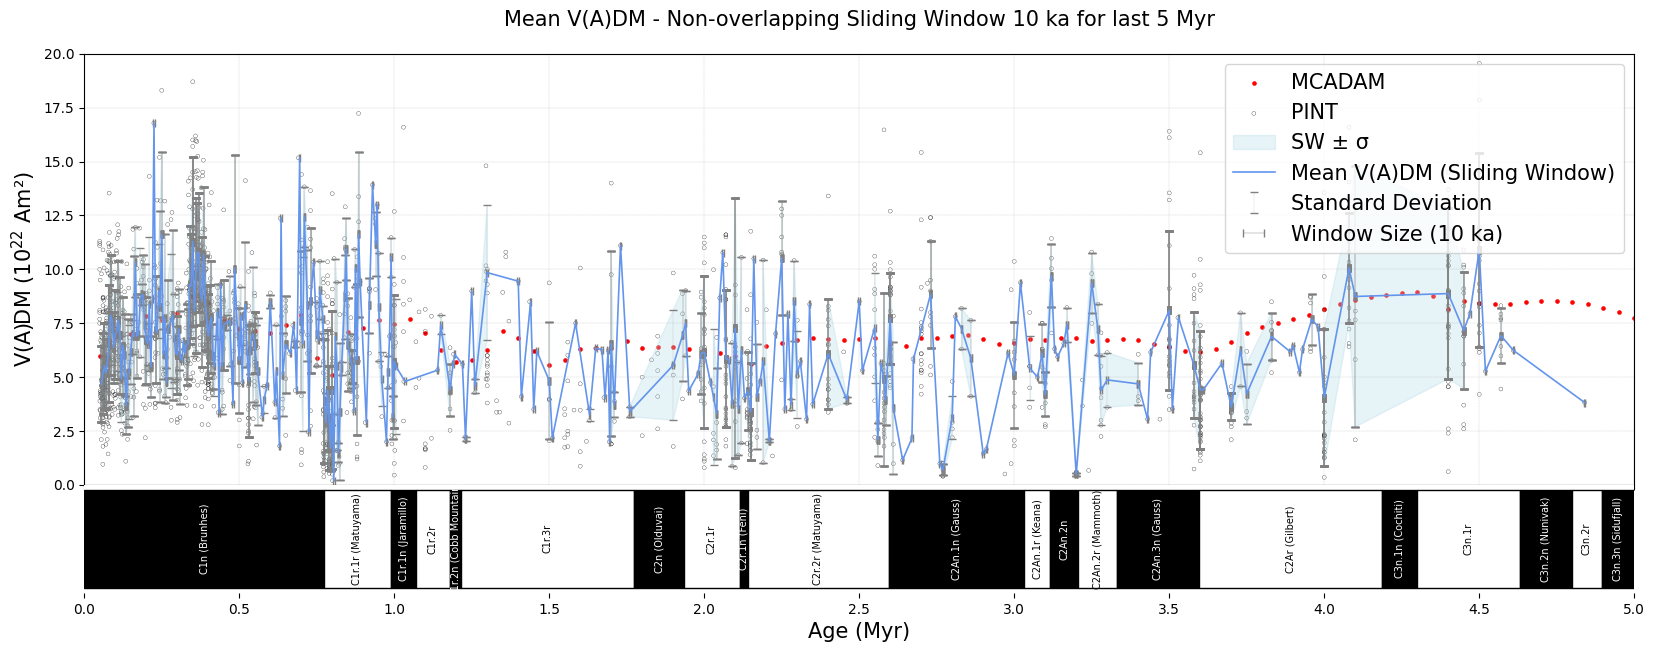

Window Step: 10, MAE: 1.1022, RMSE: 1.6798, R²: 0.4728, MAPE: 28.9938
Processing pint_10my with window_step = 20 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_20ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_20ka/imputed_data_window_20ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_20ka/plot_VADM_window_20.png


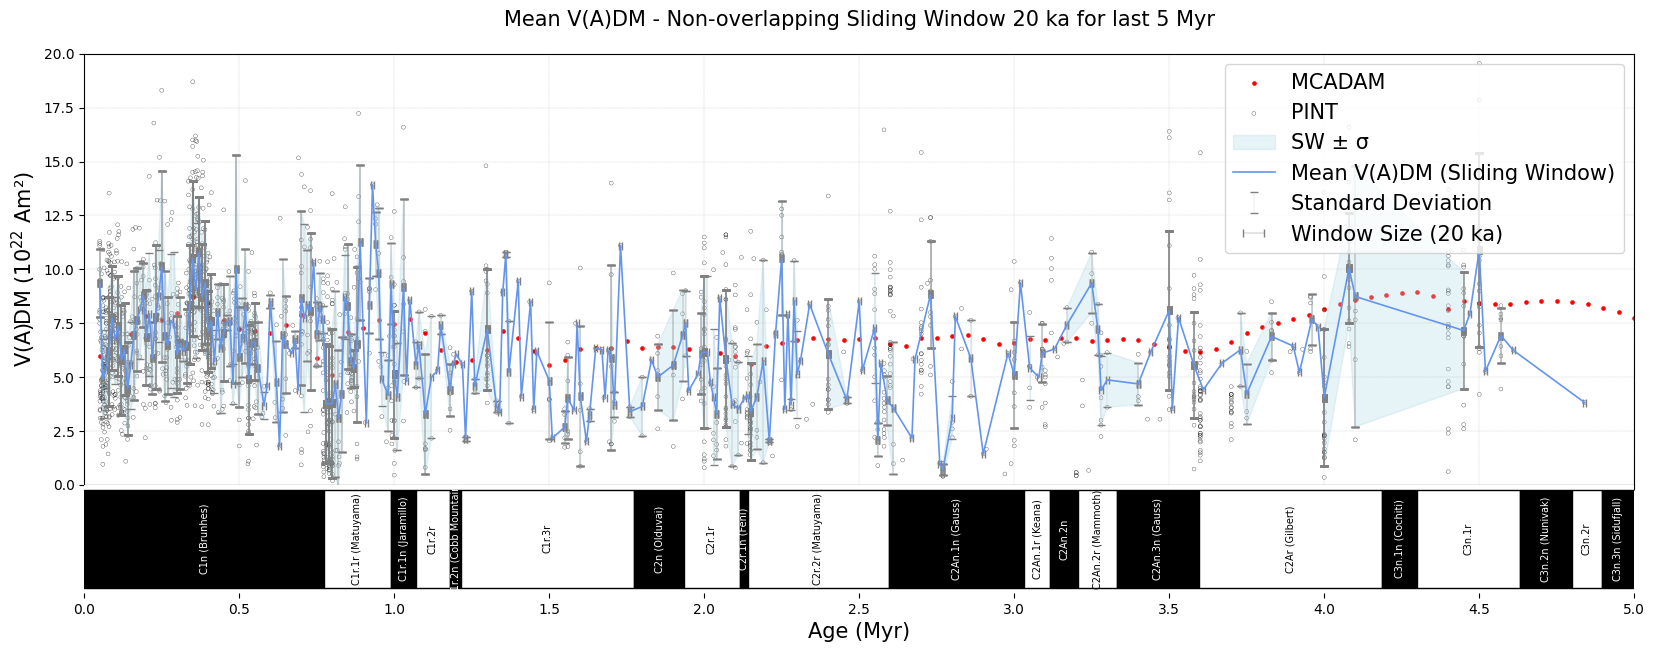

Window Step: 20, MAE: 0.7874, RMSE: 1.7283, R²: 0.4918, MAPE: 27.8697
Processing pint_10my with window_step = 50 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_50ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_50ka/imputed_data_window_50ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_50ka/plot_VADM_window_50.png


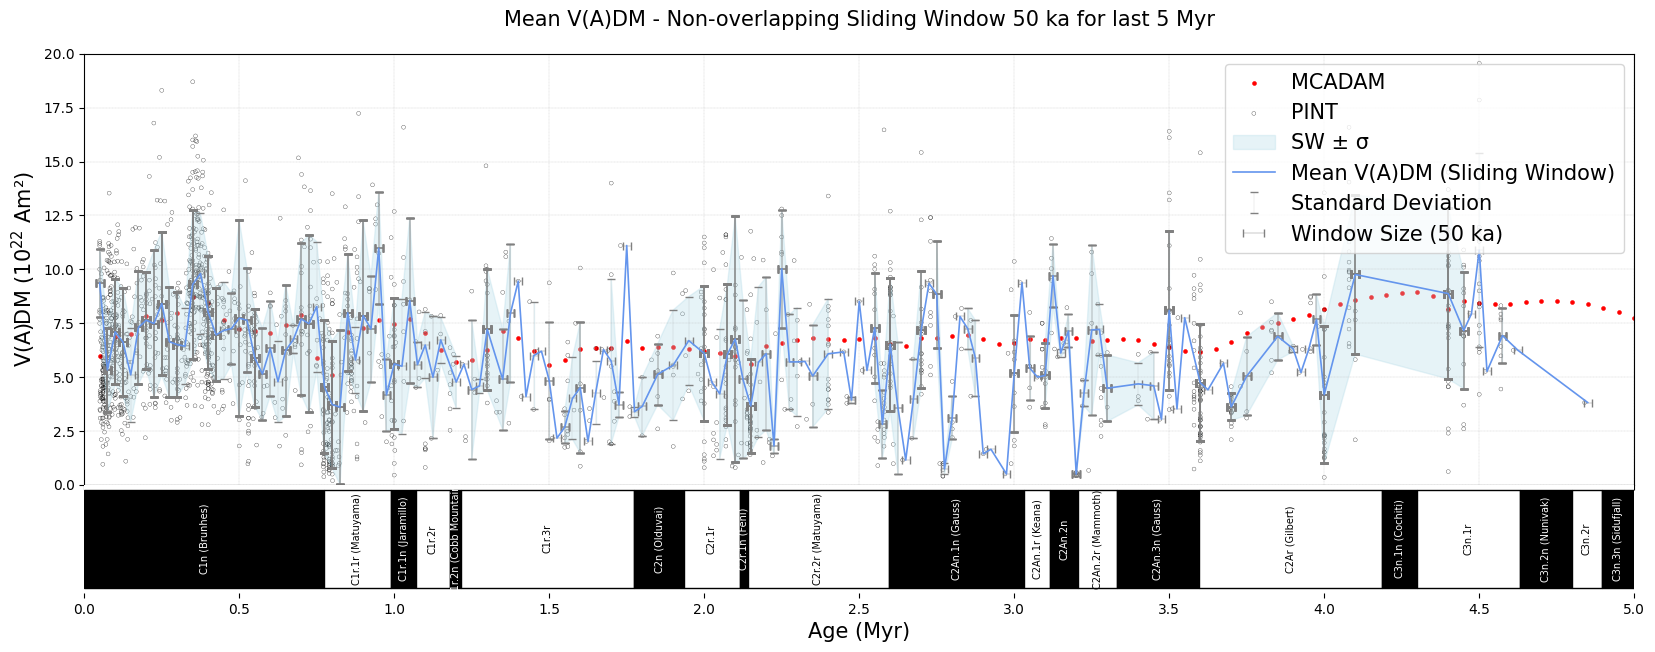

Window Step: 50, MAE: 1.2991, RMSE: 1.8996, R²: 0.3858, MAPE: 29.5290
Processing pint_10my with window_step = 100 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_100ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_100ka/imputed_data_window_100ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_100ka/plot_VADM_window_100.png


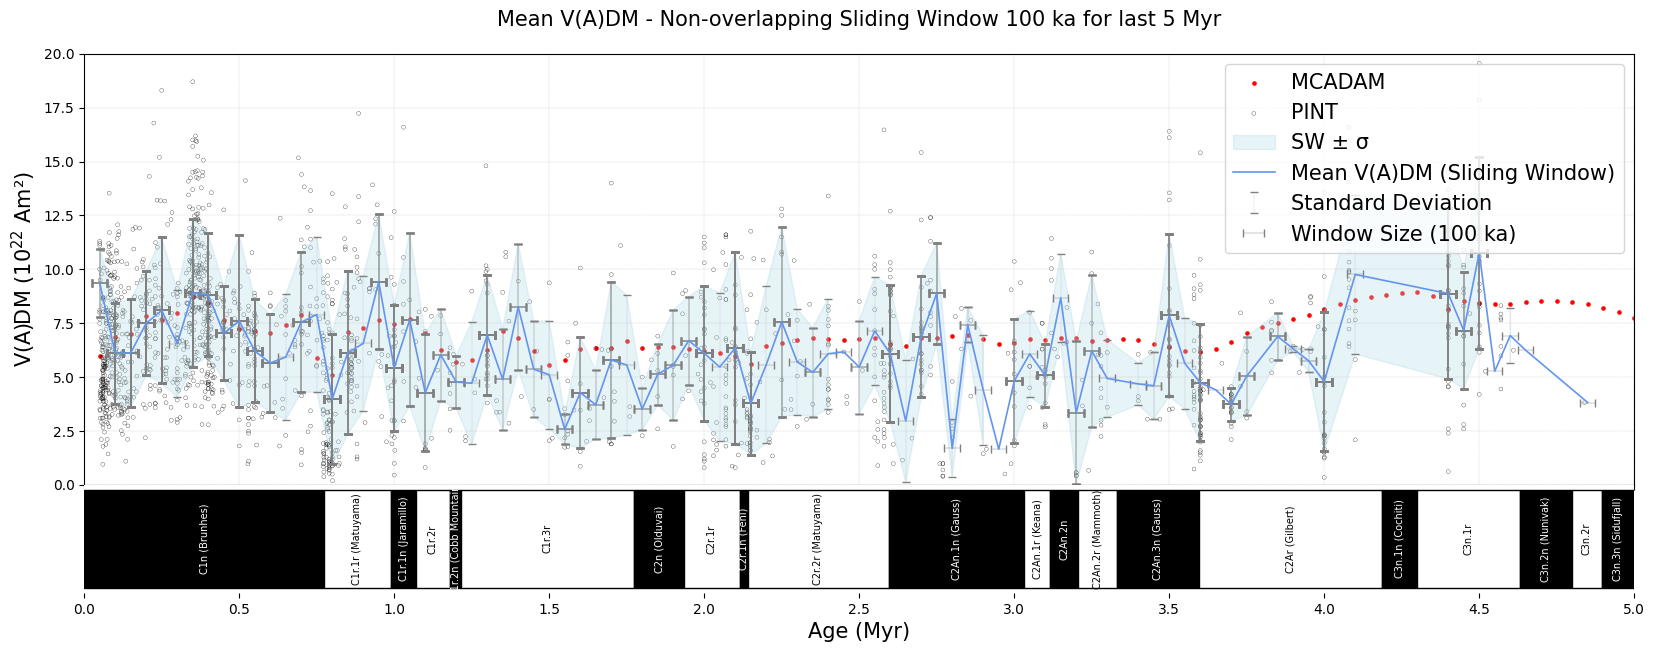

Window Step: 100, MAE: 1.5417, RMSE: 2.0917, R²: 0.2553, MAPE: 42.4176
Processing pint_10my with window_step = 200 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_200ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_200ka/imputed_data_window_200ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/window_step_200ka/plot_VADM_window_200.png


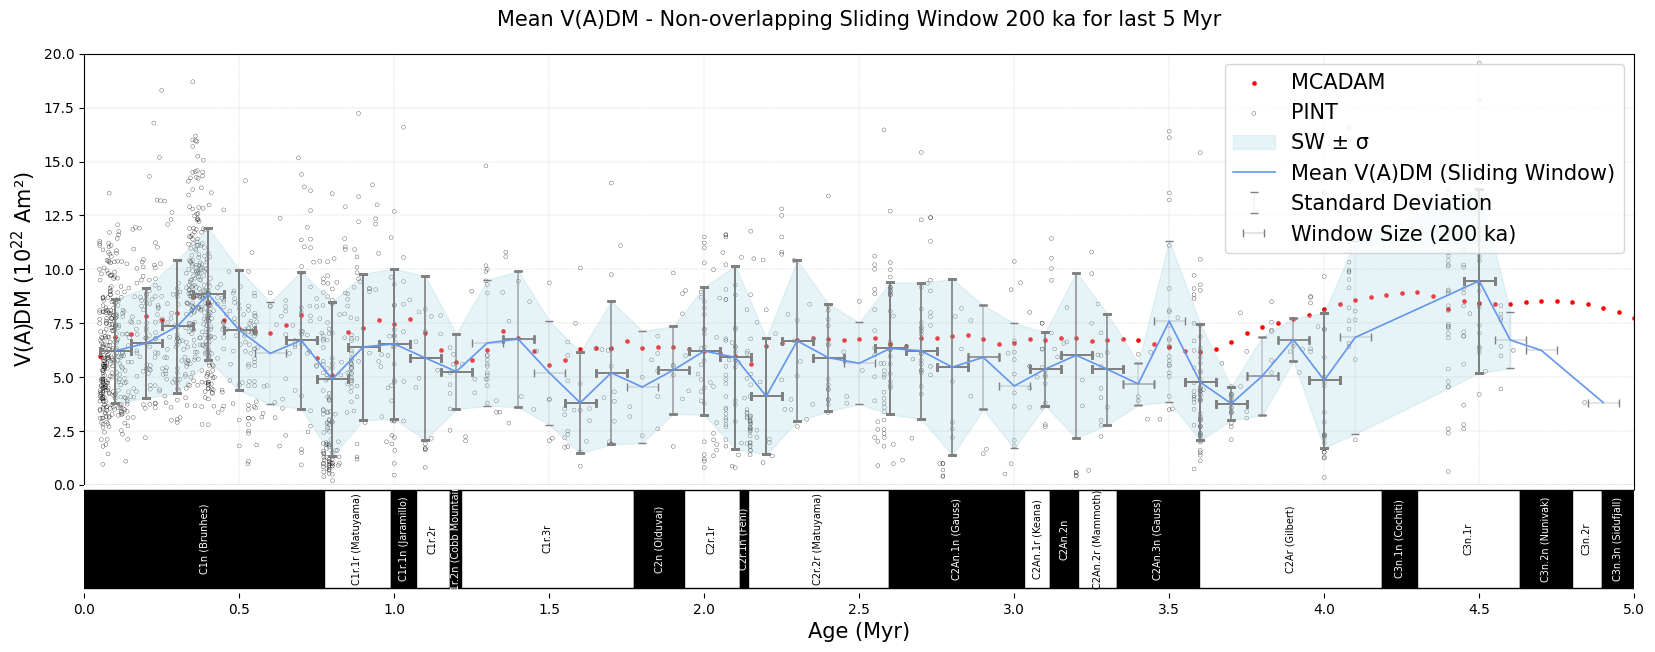

Window Step: 200, MAE: 1.7405, RMSE: 2.2755, R²: 0.1299, MAPE: 48.5436

Best window step for pint_10my: 10.0 ka
Best metrics - RMSE: 1.6798, R²: 0.4728
Metrics summary saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/metrics_summary.csv
Combined plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/all_windows.png


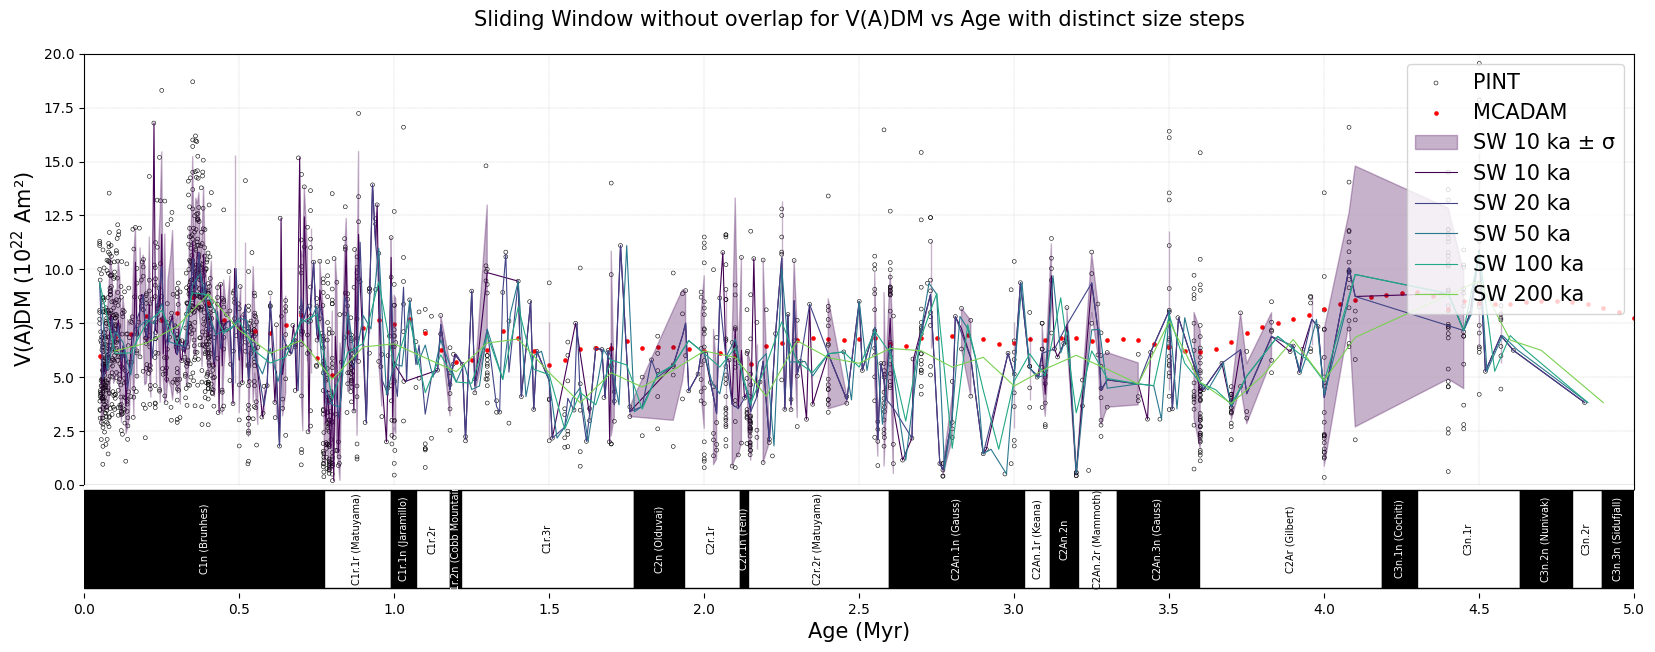

Plot de métricas vs. window_step guardado en: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/metrics_vs_window_step_pint_10my.png

--- Procesando Sliding Window con Overlap para pint_10my ---
Processing sliding window: 10 ka, overlap 50%
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_10ka_overlap_50pct
Sliding window data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_10ka_overlap_50pct/sliding_window_data_10ka_overlap_50pct.xlsx
Sliding window plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_10ka_overlap_50pct/plot_sliding_window_10ka_overlap_50pct.png


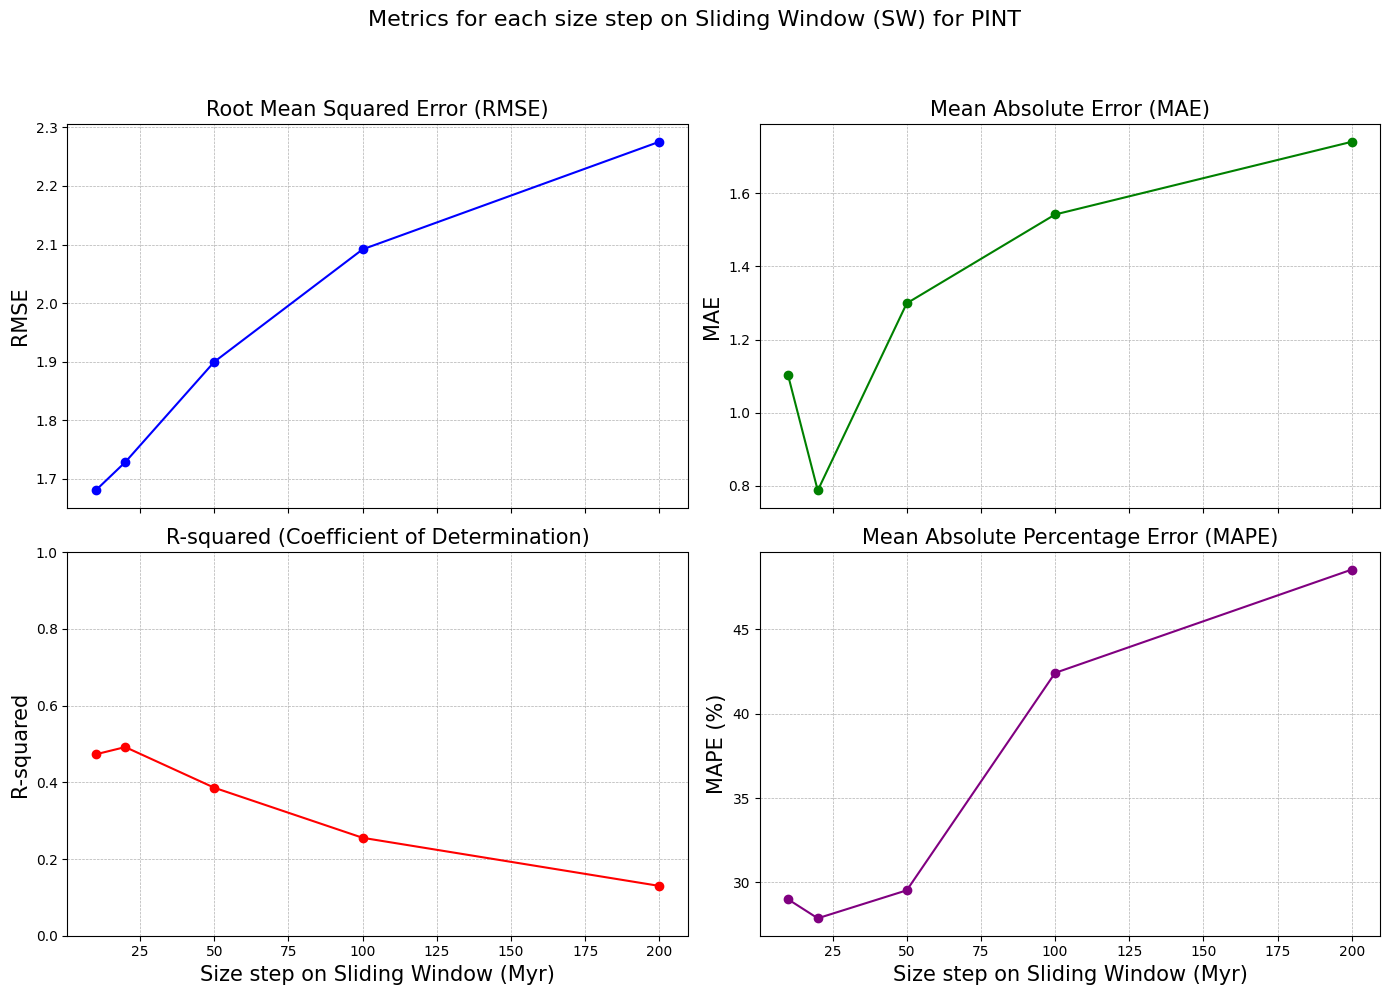

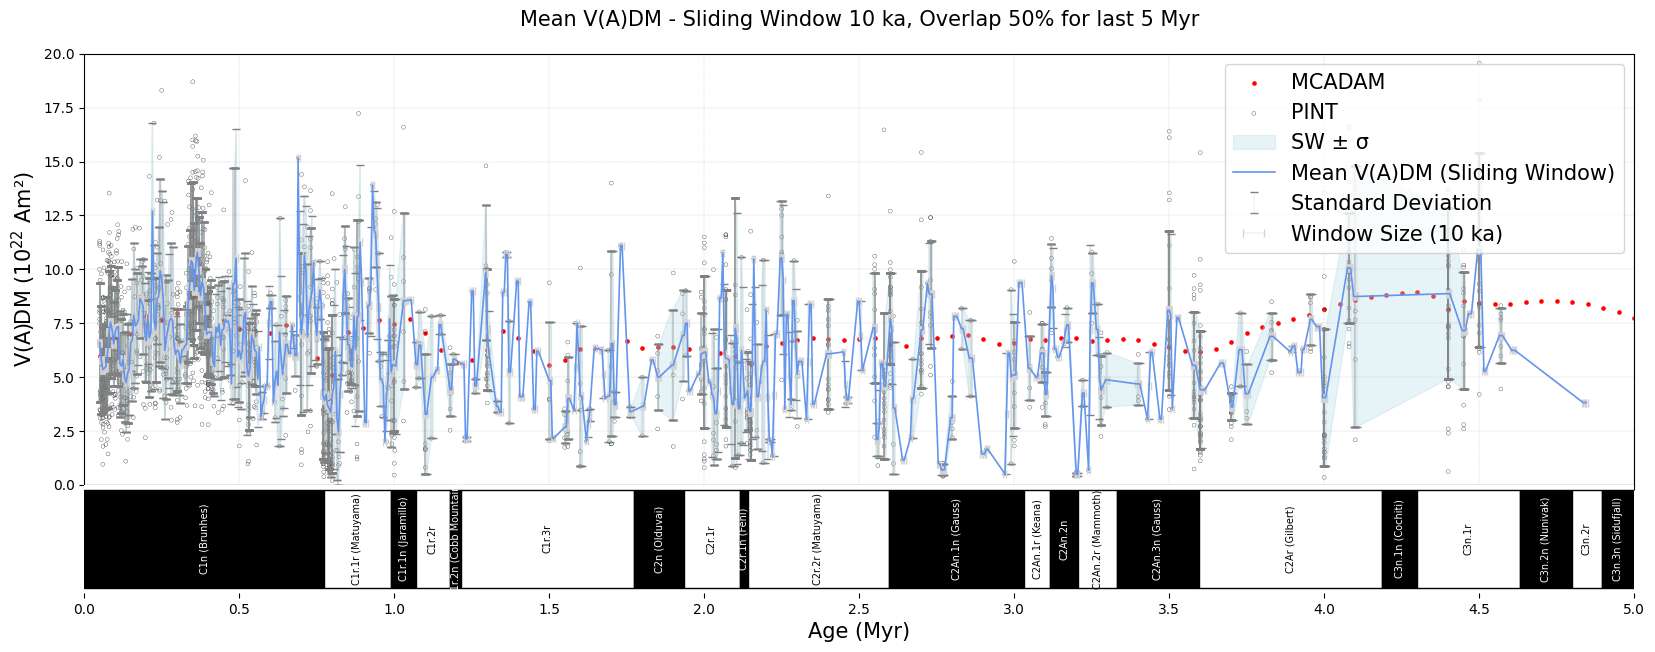

Sliding Window (10 ka, 50% overlap): MAE: 0.0496, RMSE: 0.3166, R²: 0.9829, MAPE: 0.7638
Processing sliding window: 20 ka, overlap 25%
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_20ka_overlap_25pct
Sliding window data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_20ka_overlap_25pct/sliding_window_data_20ka_overlap_25pct.xlsx
Sliding window plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_20ka_overlap_25pct/plot_sliding_window_20ka_overlap_25pct.png


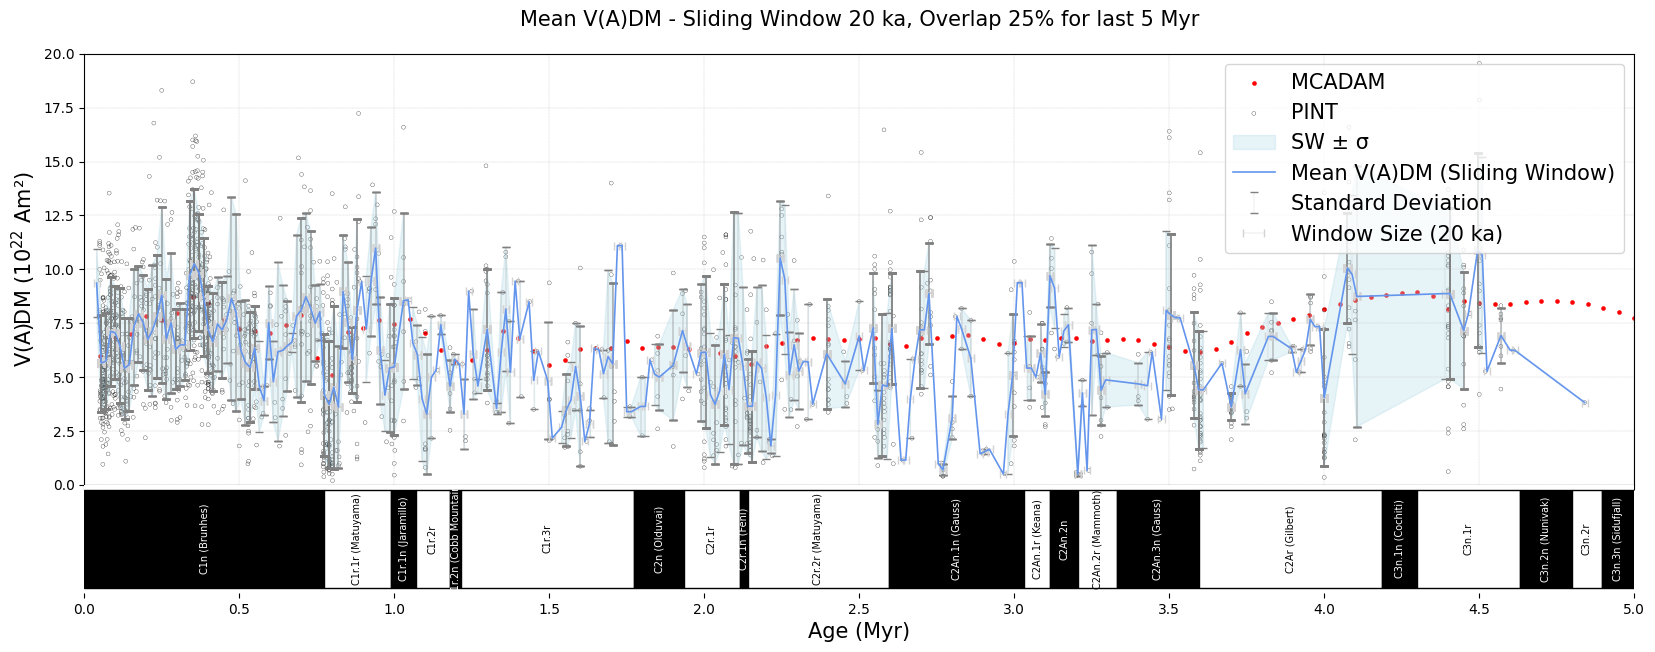

Sliding Window (20 ka, 25% overlap): MAE: 0.9159, RMSE: 1.4918, R²: 0.6214, MAPE: 19.5481
Processing sliding window: 50 ka, overlap 10%
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_50ka_overlap_10pct
Sliding window data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_50ka_overlap_10pct/sliding_window_data_50ka_overlap_10pct.xlsx
Sliding window plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_50ka_overlap_10pct/plot_sliding_window_50ka_overlap_10pct.png


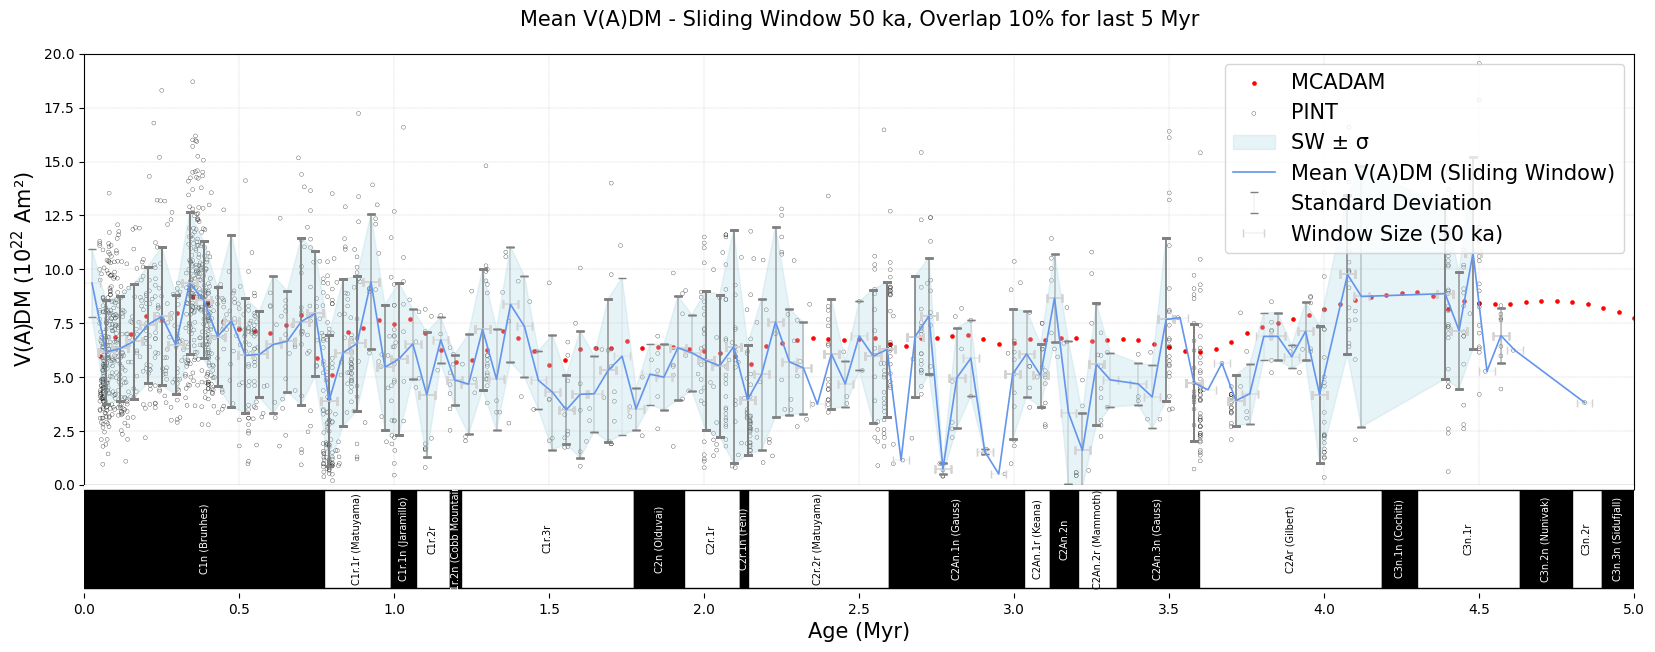

Sliding Window (50 ka, 10% overlap): MAE: 1.4188, RMSE: 1.9174, R²: 0.3742, MAPE: 32.3667
Processing sliding window: 100 ka, overlap 5%
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_100ka_overlap_5pct
Sliding window data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_100ka_overlap_5pct/sliding_window_data_100ka_overlap_5pct.xlsx
Sliding window plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_100ka_overlap_5pct/plot_sliding_window_100ka_overlap_5pct.png


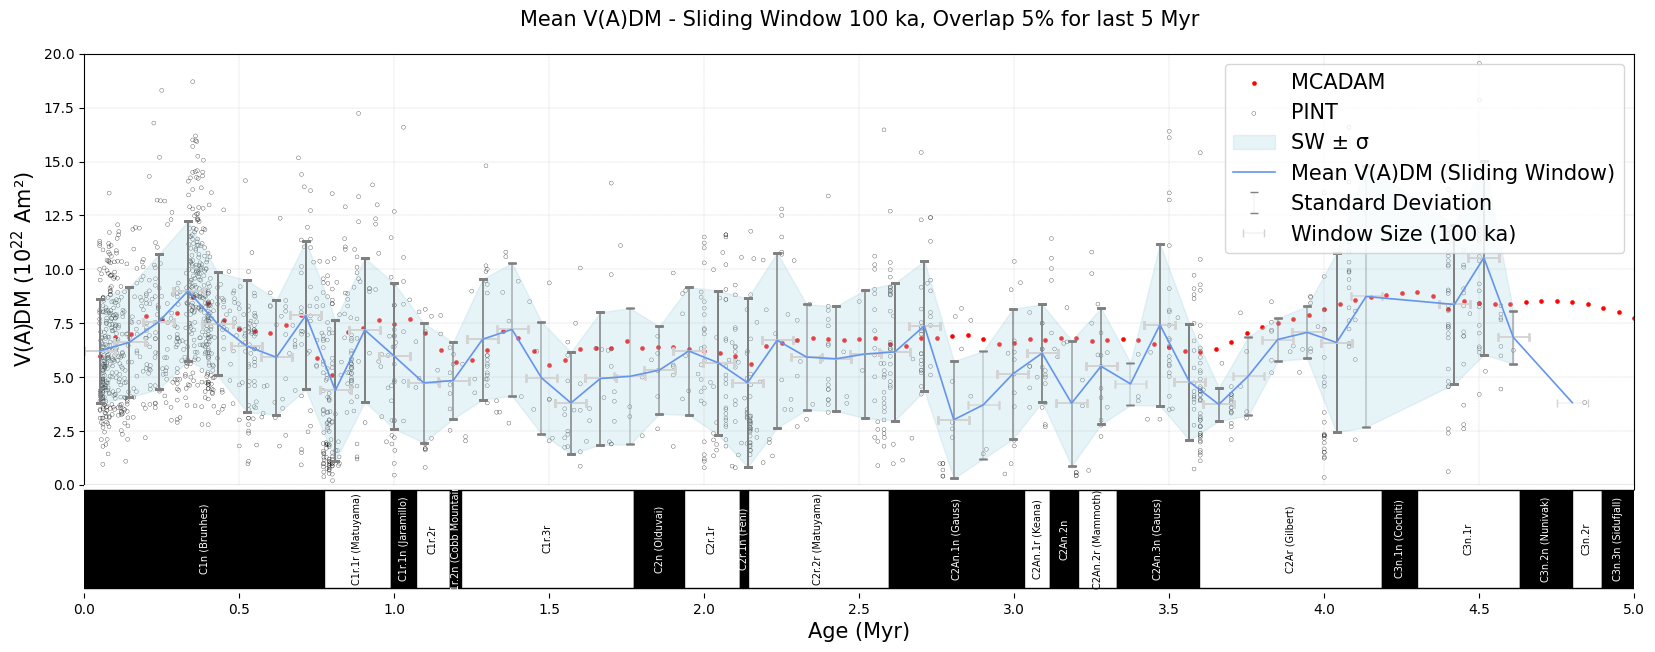

Sliding Window (100 ka, 5% overlap): MAE: 1.6845, RMSE: 2.2007, R²: 0.1760, MAPE: 45.4310
Sliding window metrics summary saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/sliding_window_metrics_summary.csv
Gráficos de métricas para ventanas deslizantes con solapamiento guardados en: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my/metrics_vs_window_and_overlap.png


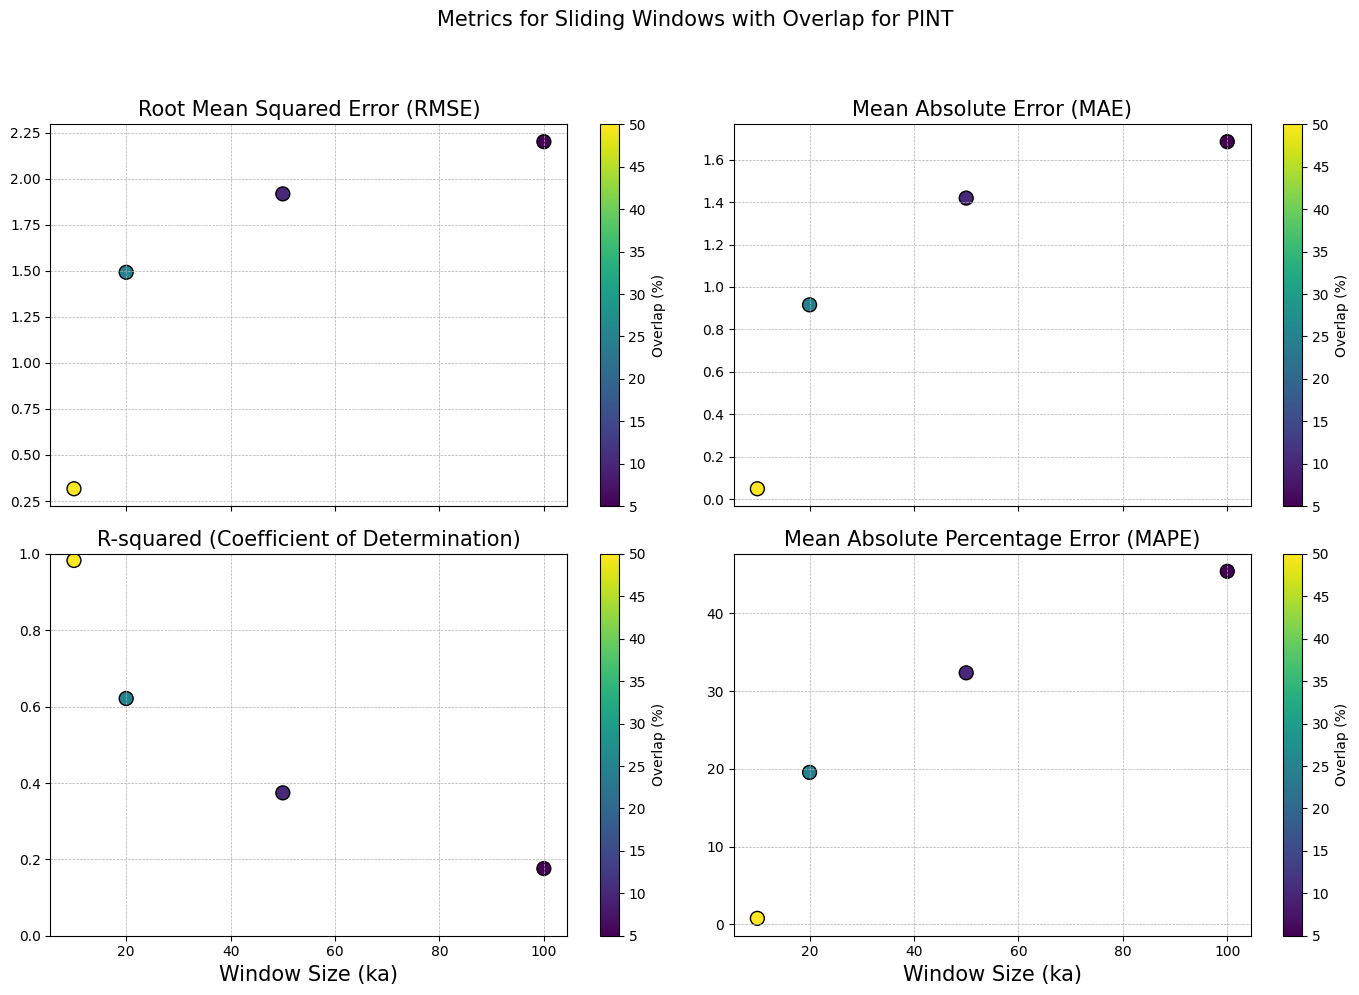

Completado procesamiento de pint_10my
Completado procesamiento de pint_10my

PROCESANDO DATASET: pint_10my_qpi_3
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3
Processing pint_10my_qpi_3 with window_step = 10 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_10ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_10ka/imputed_data_window_10ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_10ka/plot_VADM_window_10.png


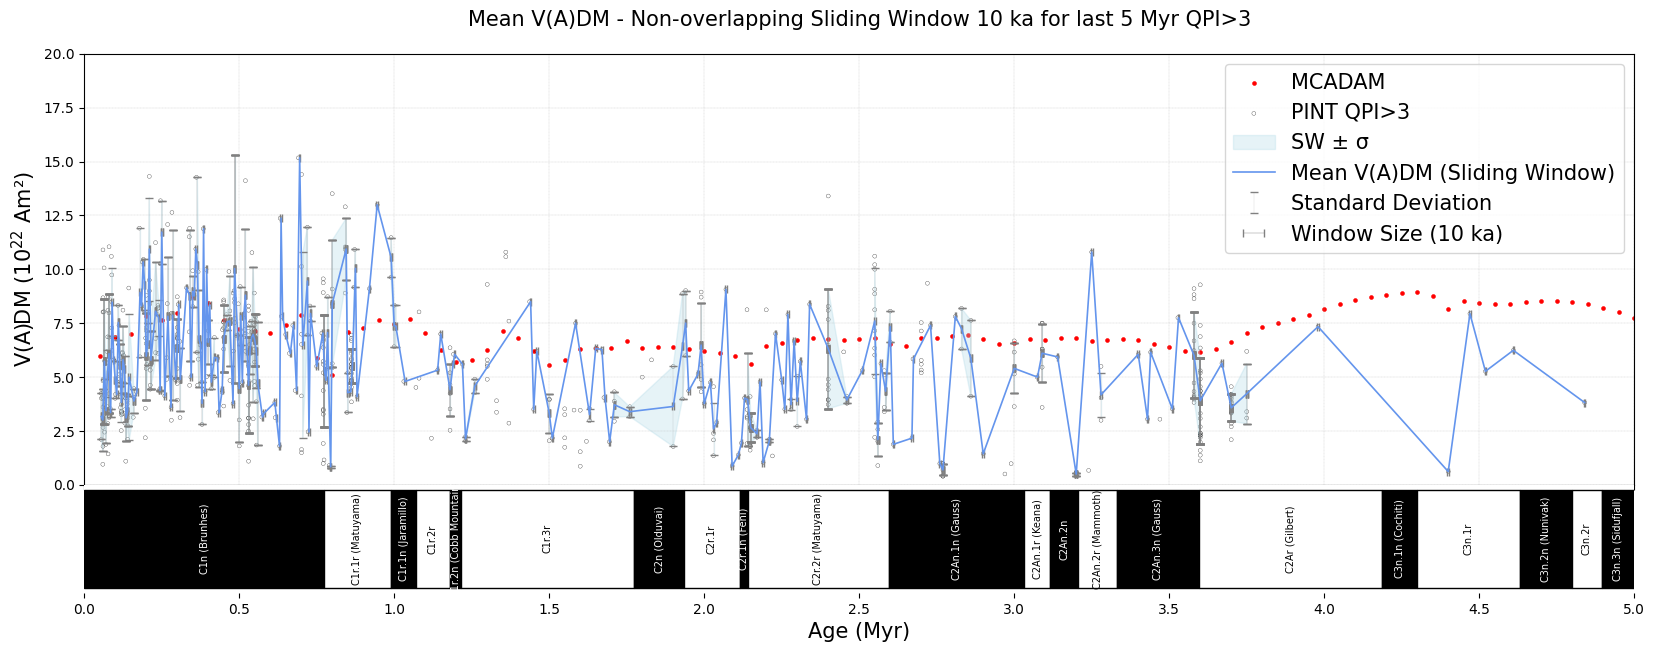

Window Step: 10, MAE: 1.0012, RMSE: 1.5707, R²: 0.6057, MAPE: 33.7624
Processing pint_10my_qpi_3 with window_step = 20 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_20ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_20ka/imputed_data_window_20ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_20ka/plot_VADM_window_20.png


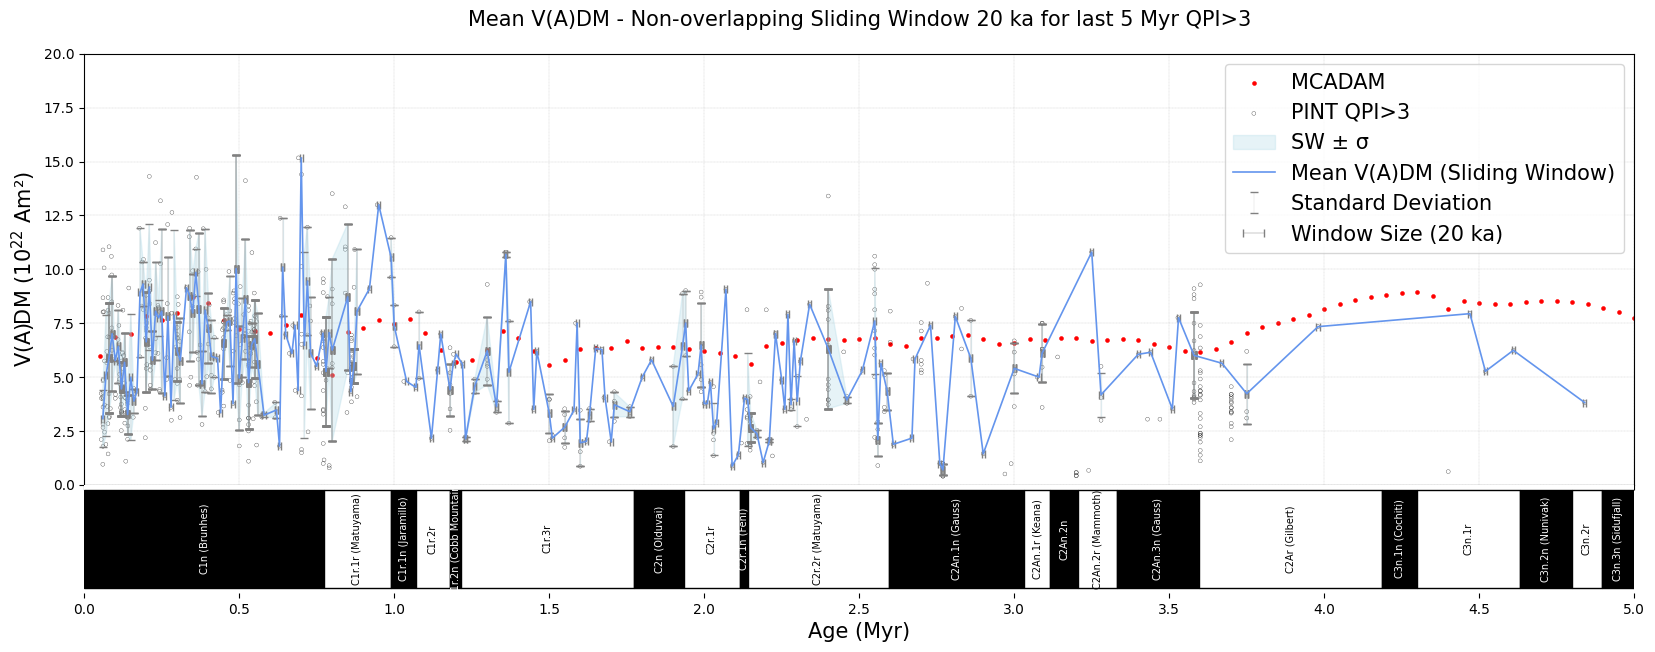

Window Step: 20, MAE: 1.0073, RMSE: 2.1405, R²: 0.2844, MAPE: 47.8906
Processing pint_10my_qpi_3 with window_step = 50 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_50ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_50ka/imputed_data_window_50ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_50ka/plot_VADM_window_50.png


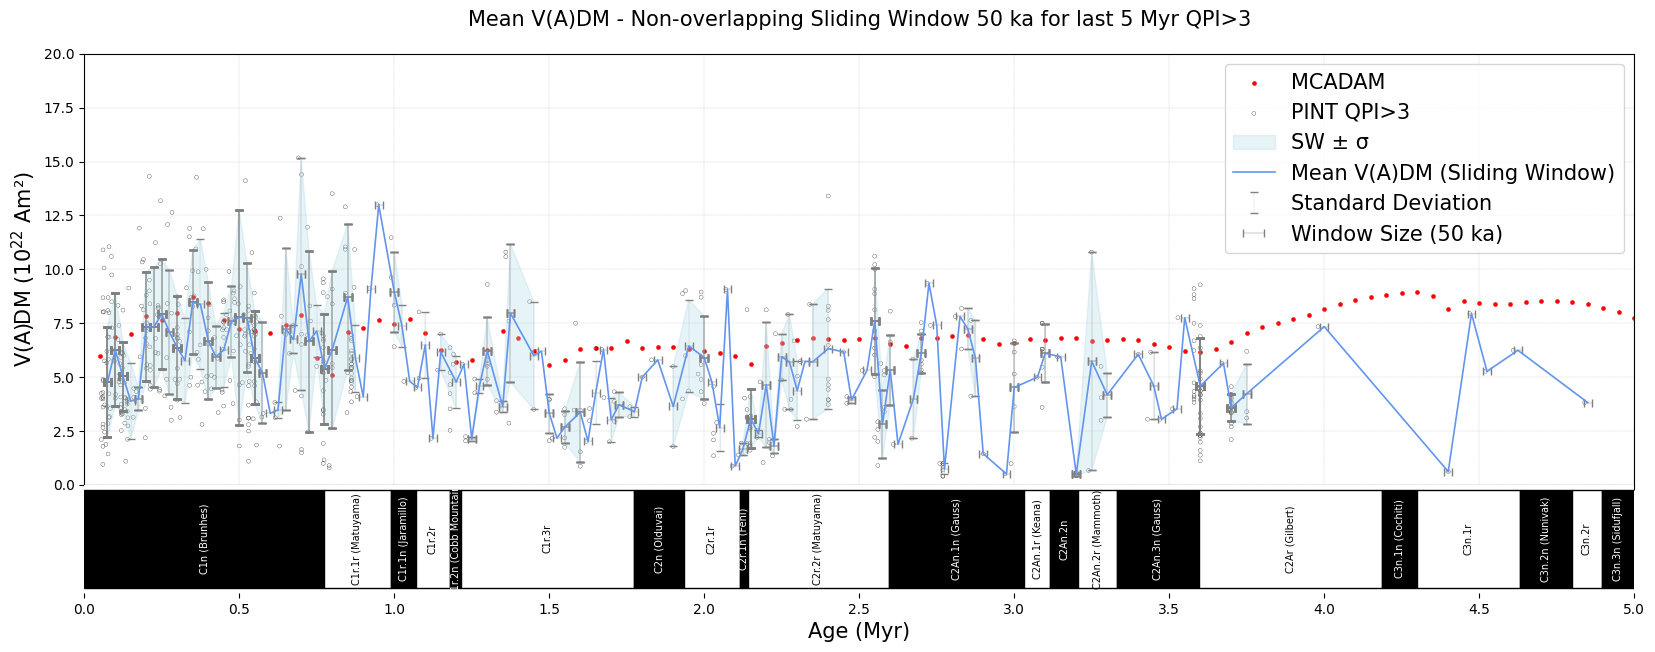

Window Step: 50, MAE: 1.1438, RMSE: 1.7262, R²: 0.5390, MAPE: 32.9553
Processing pint_10my_qpi_3 with window_step = 100 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_100ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_100ka/imputed_data_window_100ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_100ka/plot_VADM_window_100.png


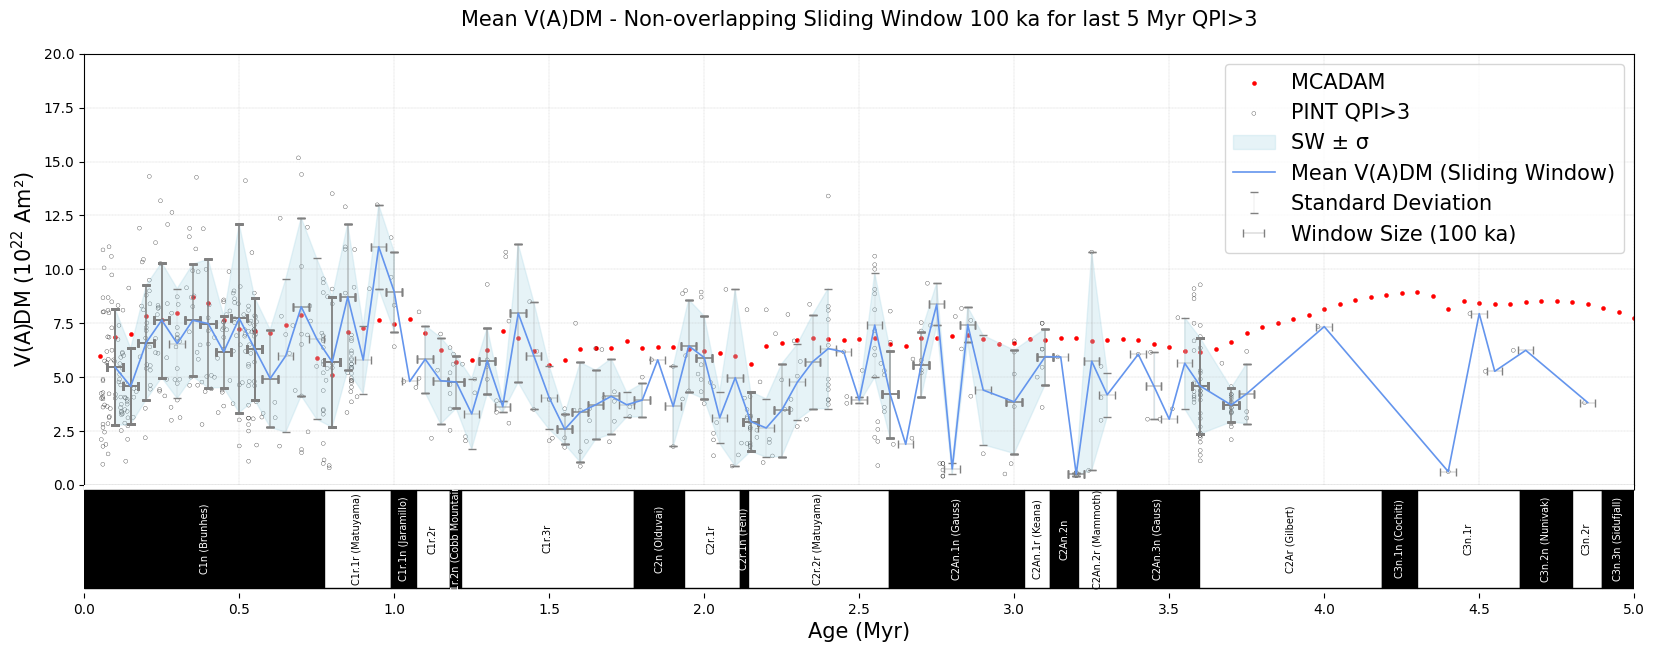

Window Step: 100, MAE: 1.5832, RMSE: 2.1038, R²: 0.3153, MAPE: 48.7376
Processing pint_10my_qpi_3 with window_step = 200 ka
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_200ka
Imputed data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_200ka/imputed_data_window_200ka.xlsx
Plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/window_step_200ka/plot_VADM_window_200.png


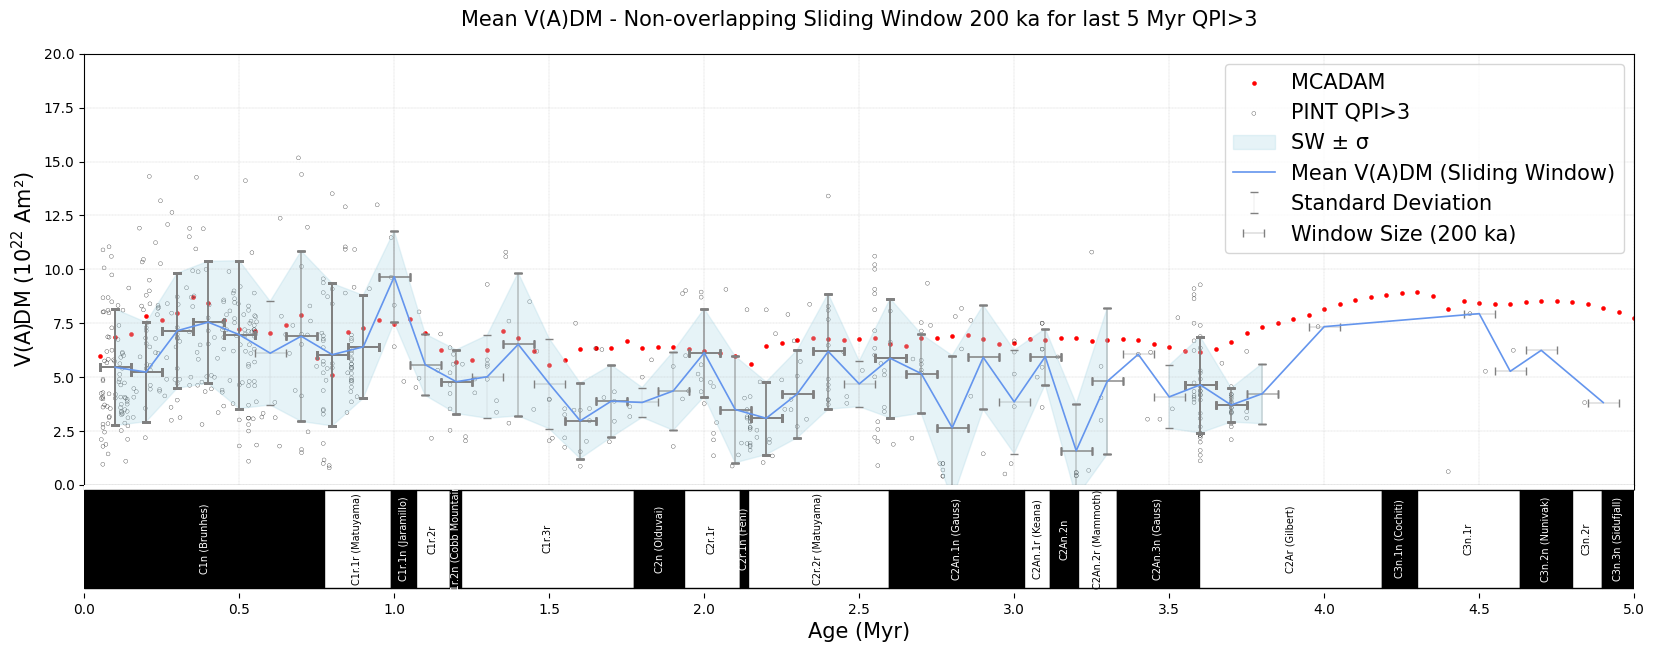

Window Step: 200, MAE: 1.7879, RMSE: 2.3160, R²: 0.1701, MAPE: 55.6888

Best window step for pint_10my_qpi_3: 10.0 ka
Best metrics - RMSE: 1.5707, R²: 0.6057
Metrics summary saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/metrics_summary.csv
Combined plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/all_windows.png


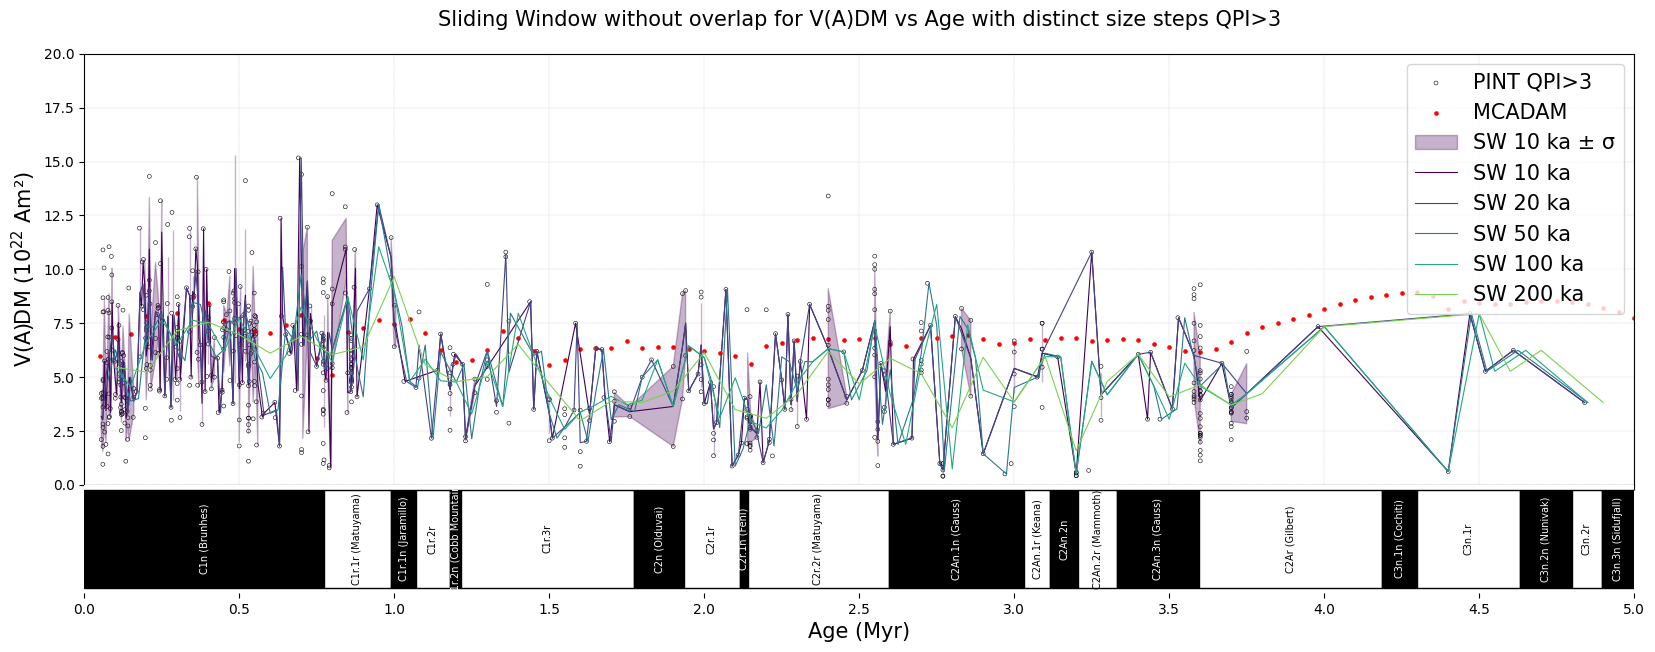

Plot de métricas vs. window_step guardado en: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/metrics_vs_window_step_pint_10my_qpi_3.png

--- Procesando Sliding Window con Overlap para pint_10my_qpi_3 ---
Processing sliding window: 10 ka, overlap 50%
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_10ka_overlap_50pct
Sliding window data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_10ka_overlap_50pct/sliding_window_data_10ka_overlap_50pct.xlsx
Sliding window plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_10ka_overlap_50pct/plot_sliding_window_10ka_overlap_50pct.png


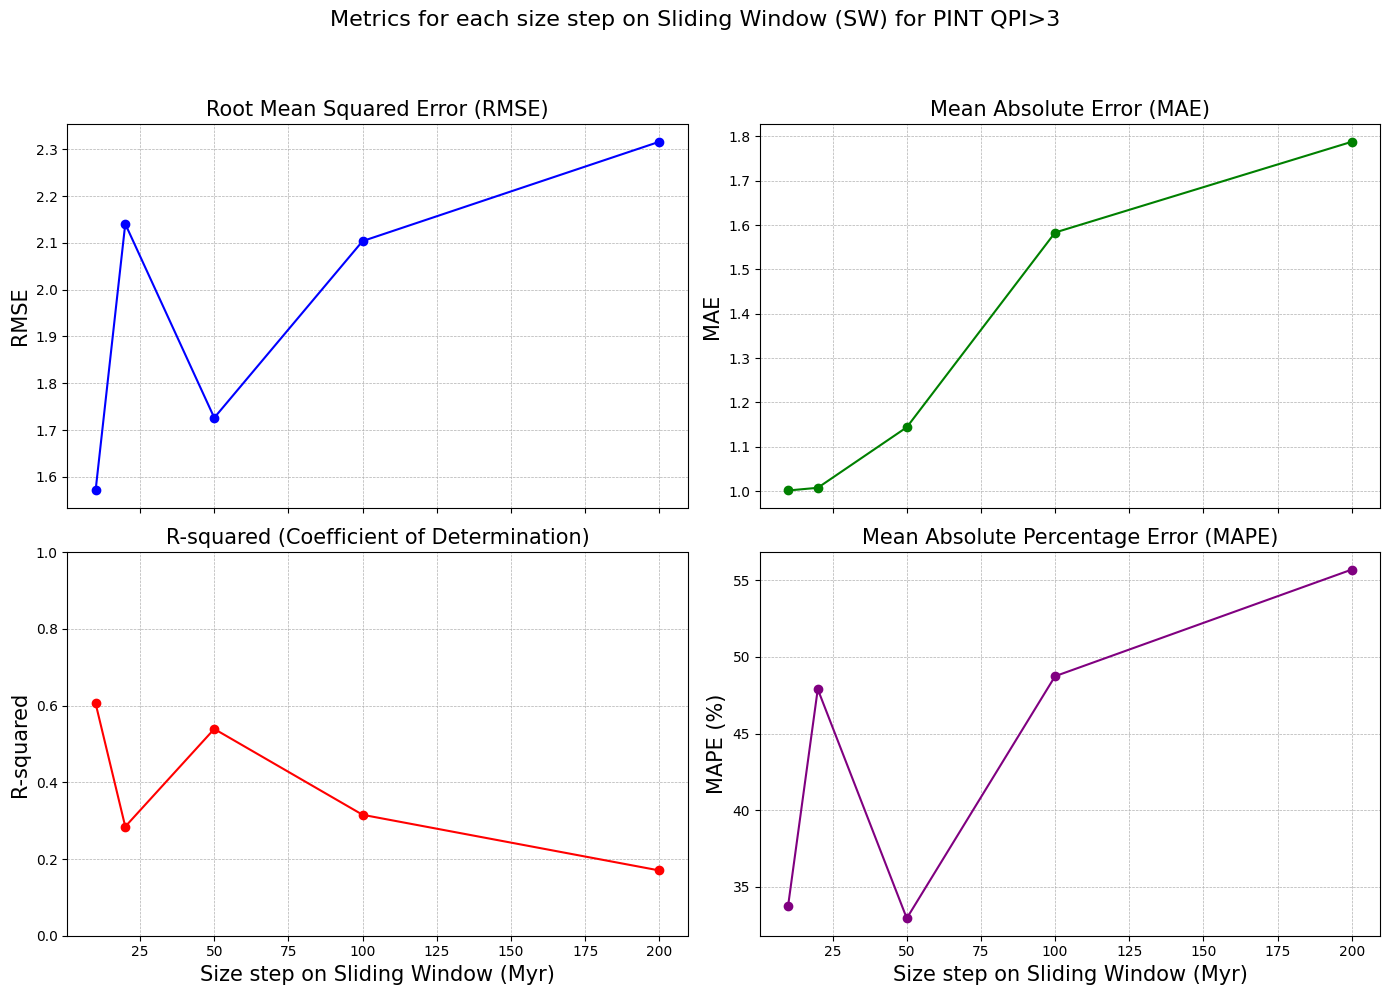

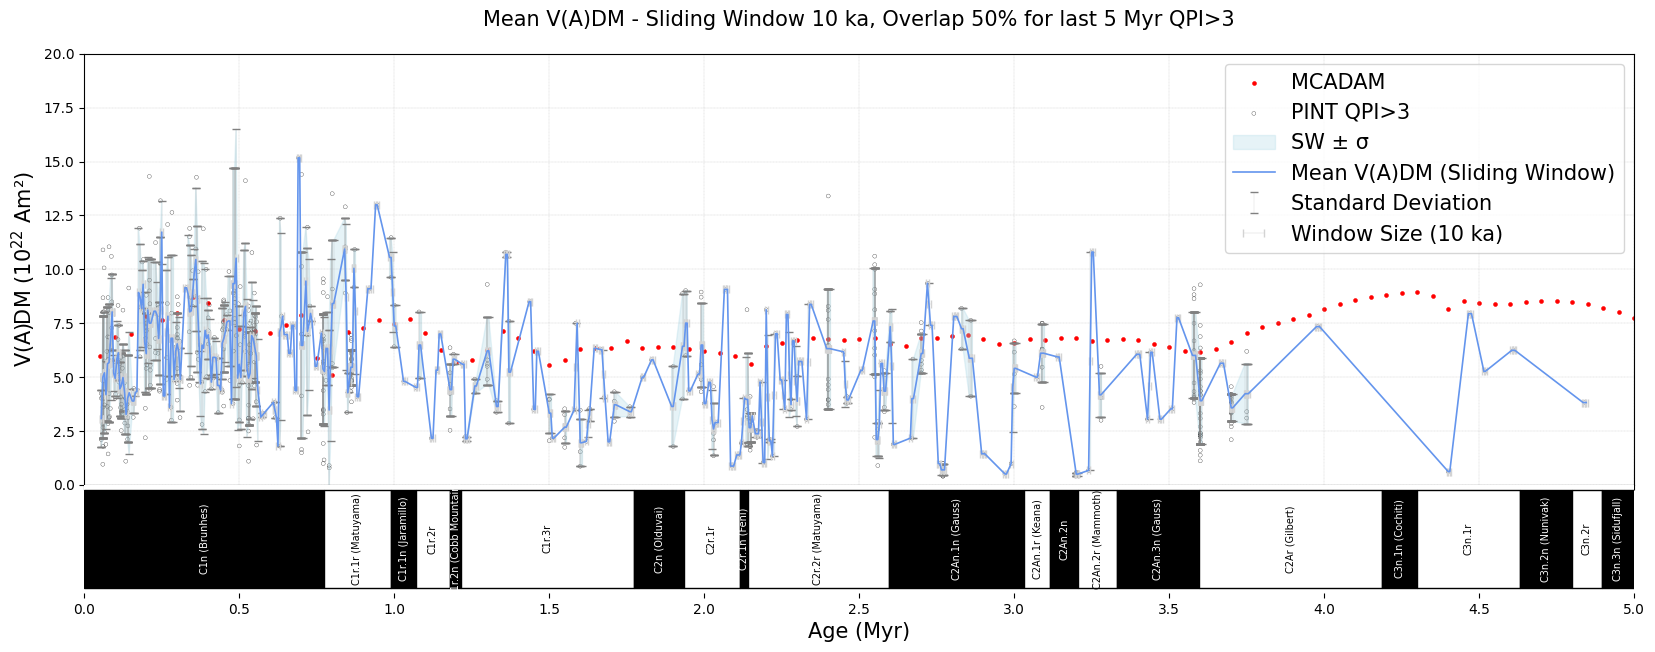

Sliding Window (10 ka, 50% overlap): MAE: 0.5475, RMSE: 1.1354, R²: 0.7940, MAPE: 12.5394
Processing sliding window: 20 ka, overlap 25%
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_20ka_overlap_25pct
Sliding window data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_20ka_overlap_25pct/sliding_window_data_20ka_overlap_25pct.xlsx
Sliding window plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_20ka_overlap_25pct/plot_sliding_window_20ka_overlap_25pct.png


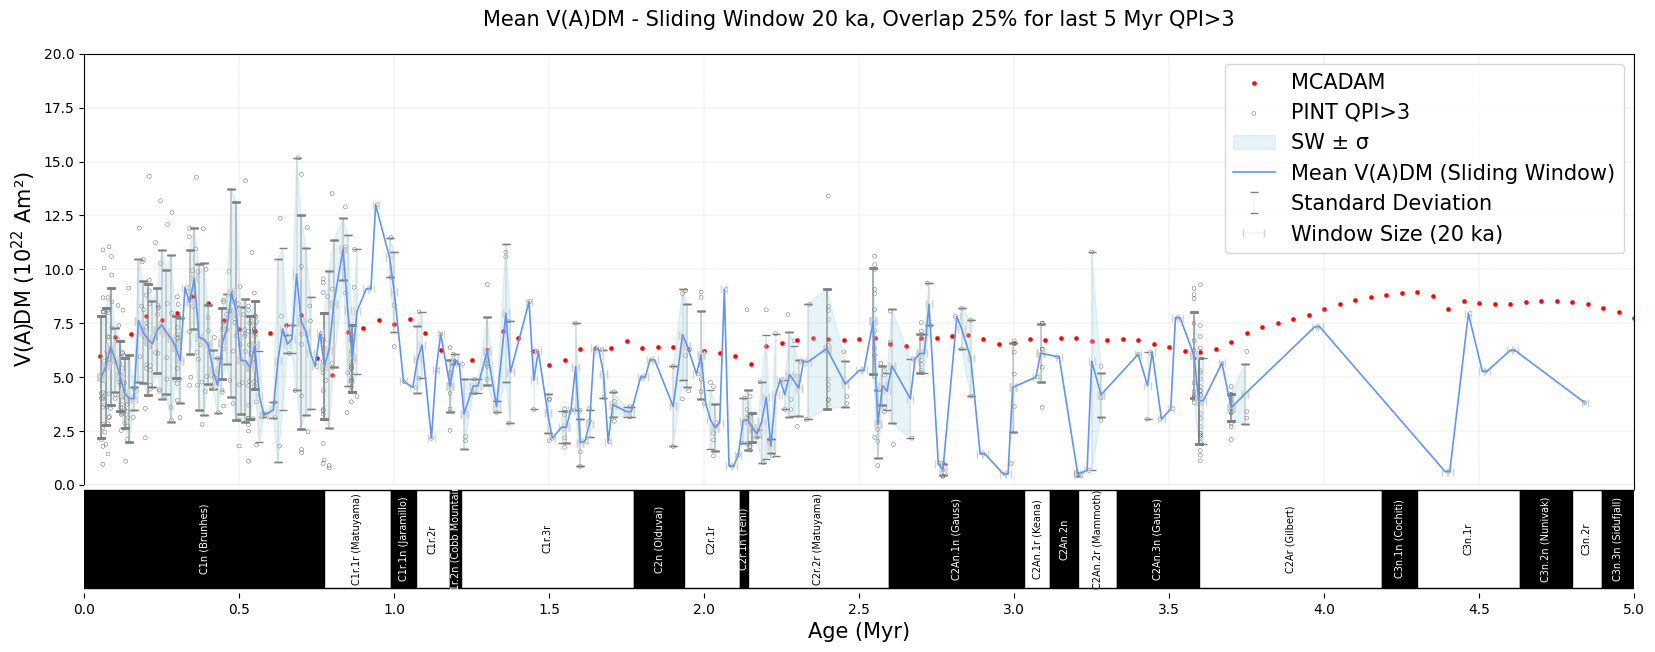

Sliding Window (20 ka, 25% overlap): MAE: 0.9773, RMSE: 1.6102, R²: 0.5977, MAPE: 28.3249
Processing sliding window: 50 ka, overlap 10%
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_50ka_overlap_10pct
Sliding window data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_50ka_overlap_10pct/sliding_window_data_50ka_overlap_10pct.xlsx
Sliding window plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_50ka_overlap_10pct/plot_sliding_window_50ka_overlap_10pct.png


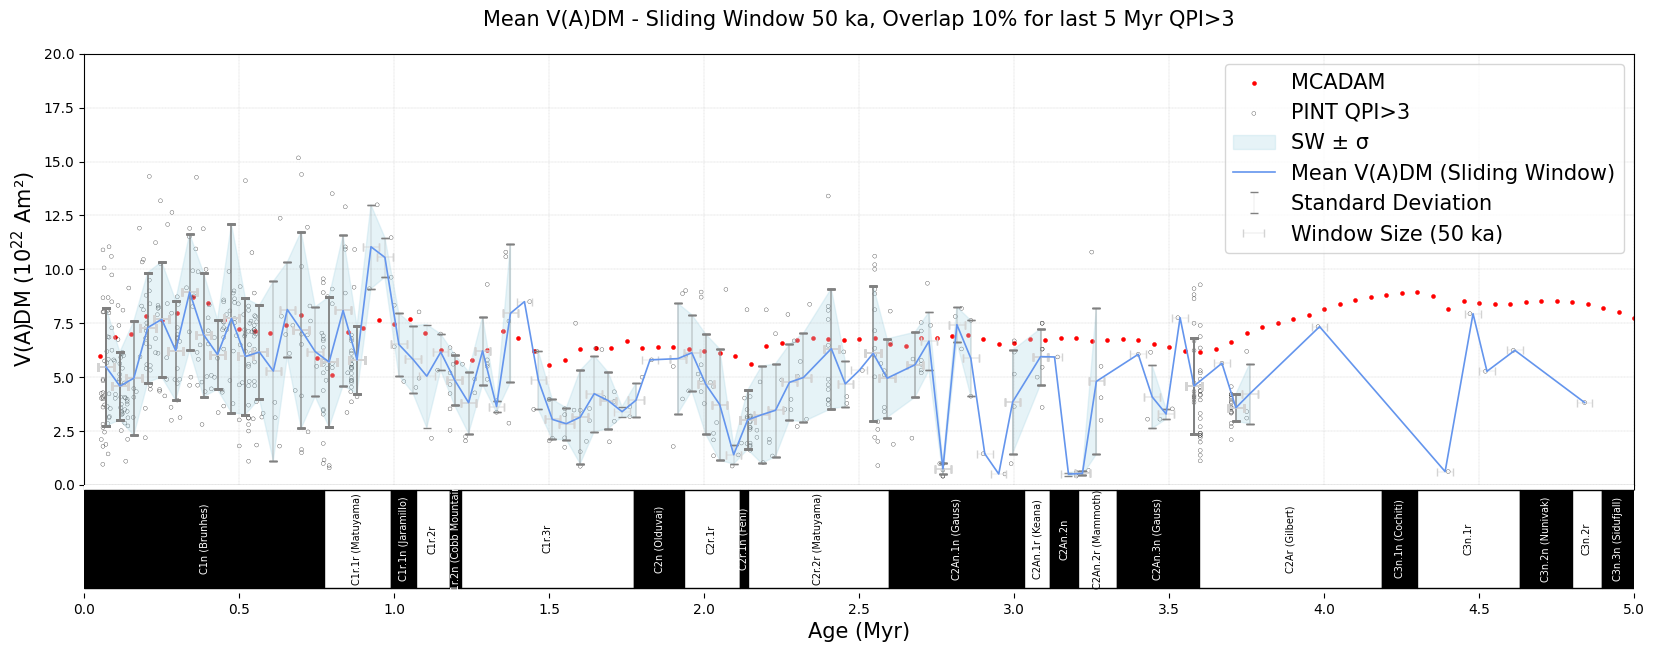

Sliding Window (50 ka, 10% overlap): MAE: 1.3551, RMSE: 1.8573, R²: 0.4625, MAPE: 33.7303
Processing sliding window: 100 ka, overlap 5%
Directorio creado: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_100ka_overlap_5pct
Sliding window data saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_100ka_overlap_5pct/sliding_window_data_100ka_overlap_5pct.xlsx
Sliding window plot saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_100ka_overlap_5pct/plot_sliding_window_100ka_overlap_5pct.png


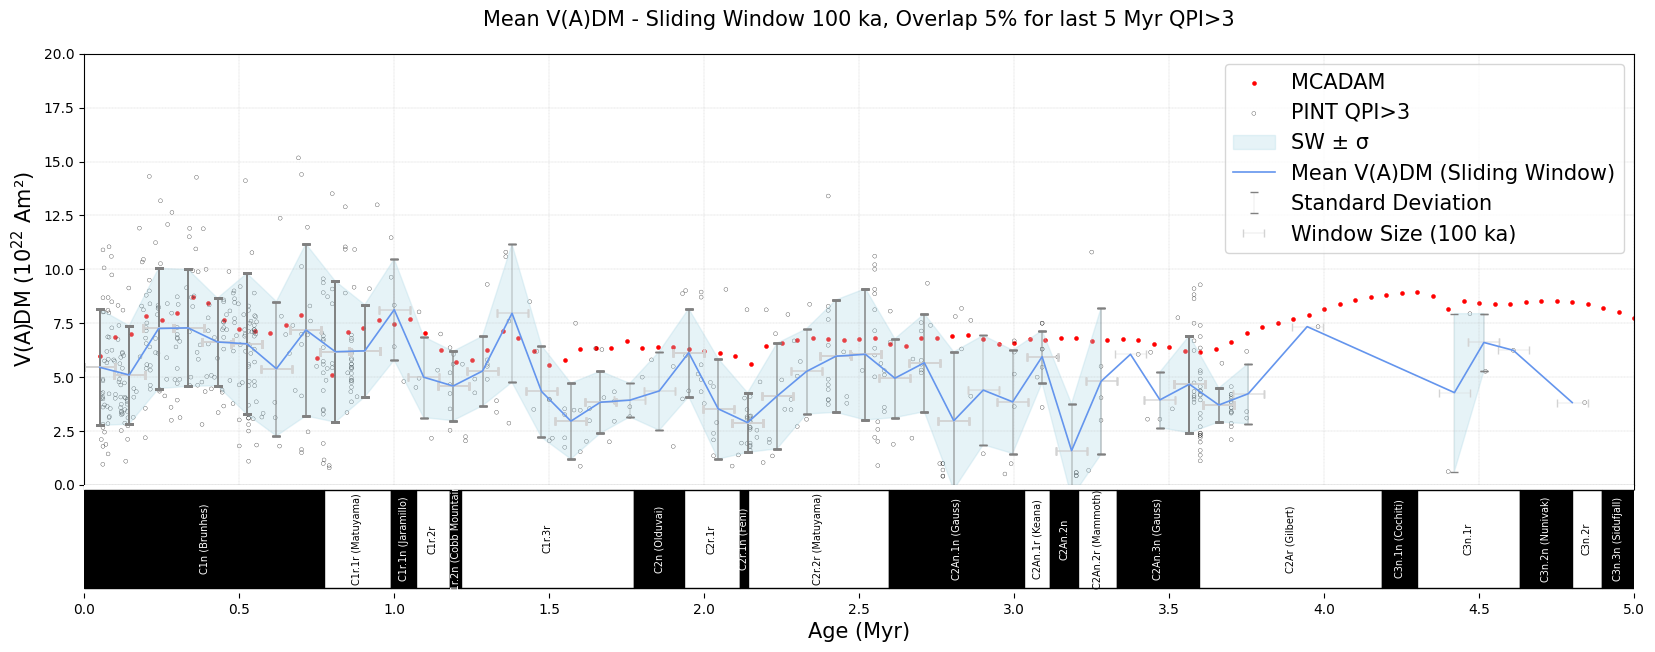

Sliding Window (100 ka, 5% overlap): MAE: 1.6689, RMSE: 2.1598, R²: 0.2567, MAPE: 52.0493
Sliding window metrics summary saved to: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/sliding_window_metrics_summary.csv
Gráficos de métricas para ventanas deslizantes con solapamiento guardados en: /content/drive/MyDrive/Projeto_PM/run_20250921_224758/pint_10my_qpi_3/metrics_vs_window_and_overlap.png


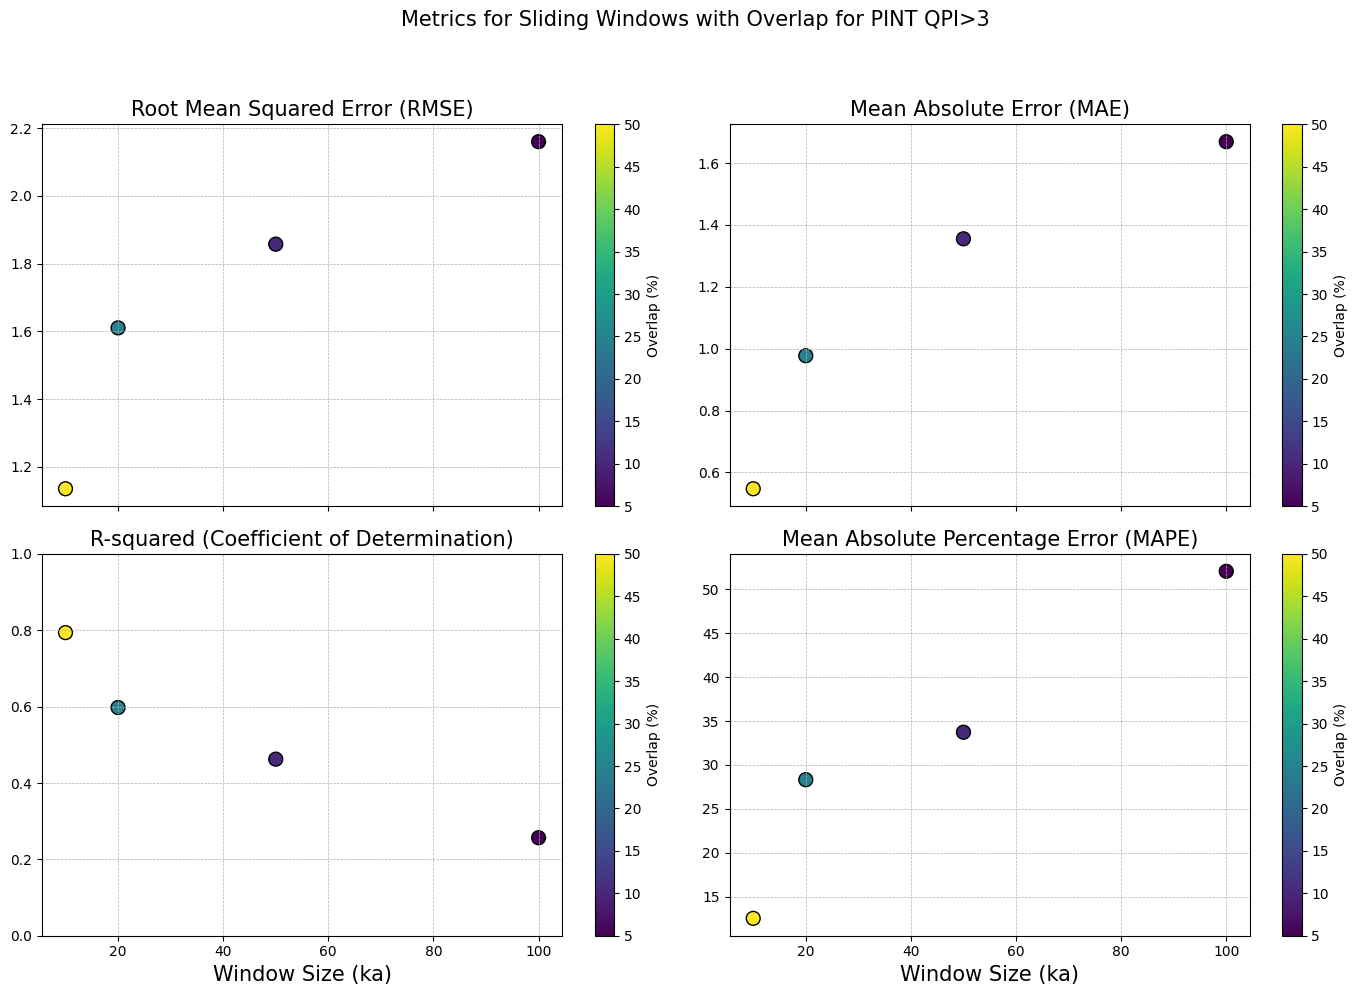

Completado procesamiento de pint_10my_qpi_3
Completado procesamiento de pint_10my_qpi_3

COMPILANDO TODOS LOS RESULTADOS...
Compilando resultados de simulaciones...
Usando solo la simulación más reciente: run_20250921_224758
Resultados compilados guardados en: /content/drive/MyDrive/Projeto_PM/compiled_simulation_results.xlsx
Total de resultados: 18
- Sliding Windows (Non-overlapping): 10
- Sliding Windows (With Overlap): 8

--- MEJORES RESULTADOS POR QPI CRITERIA ---

No QPI filter:
  🏆 Best Overall: Sliding Window (With Overlap) - 10.0 ka
      Overlap: 50% - RMSE: 0.3166

QPI > 3:
  🏆 Best Overall: Sliding Window (With Overlap) - 10.0 ka
      Overlap: 50% - RMSE: 1.1354
Gráficos comparativos guardados en: /content/drive/MyDrive/Projeto_PM/sliding_windows_comparison_plots.png


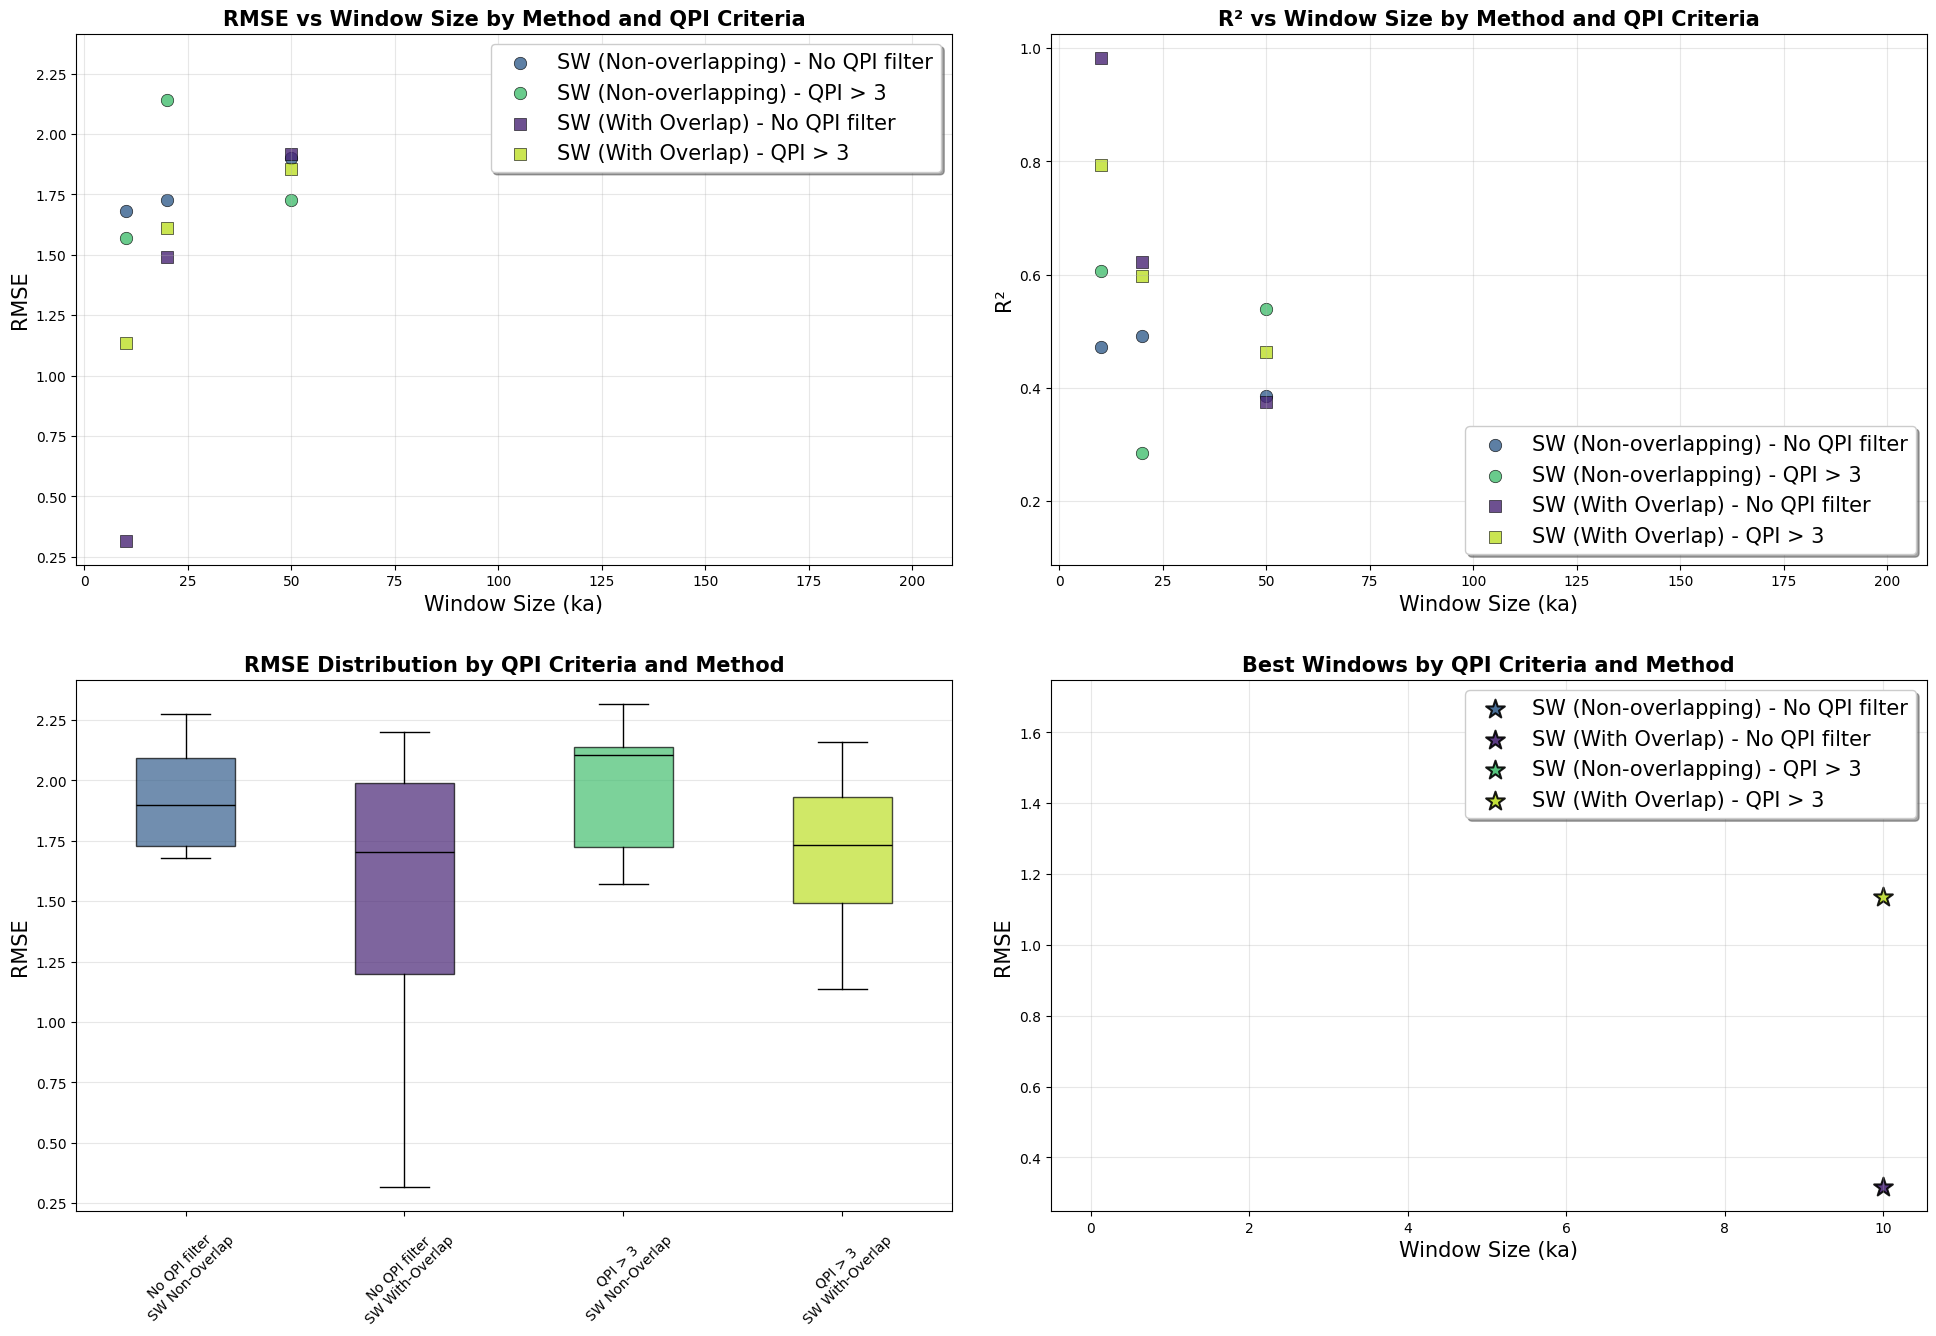

Información del esquema de colores viridis guardada en: /content/drive/MyDrive/Projeto_PM/viridis_color_scheme_info.png

¡Compilación completada!


In [44]:
if __name__ == "__main__":
    # Lista de window_steps para testar
    window_steps = [0.005, 0.01, 0.025, 0.05, 0.1]  # 10ka, 20ka, 100ka. 0.025,  0.1

    # Parámetros PARA SLIDING WINDOW:
    sliding_window_params = [
        {'window_size': 0.01, 'overlap_percent': 0.5},   # 10ka window, 50% overlap
        {'window_size': 0.02, 'overlap_percent': 0.25},   # 20ka window, 50% overlap

        {'window_size': 0.05, 'overlap_percent': 0.1},   # 50ka window, 25% overlap
        {'window_size': 0.1, 'overlap_percent': 0.05}     # 100ka window, 10% overlap
    ]
    # Crear directorio principal con fecha
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    main_run_dir = os.path.join(results_base_dir, f"run_{timestamp}")
    create_directory(main_run_dir)

    # ITERACIÓN PRINCIPAL POR CADA DATASET QPI
    for dataset_name, data_vadm in data_vadm_dict.items():
        print(f"\n{'='*60}")
        print(f"PROCESANDO DATASET: {dataset_name}")
        print(f"{'='*60}")

        # Crear directorio específico para este dataset
        dataset_dir = os.path.join(main_run_dir, dataset_name)
        create_directory(dataset_dir)

        # Archivo para guardar métricas de este dataset
        metrics_file = os.path.join(dataset_dir, "metrics_summary.csv")
        metrics_data = []
        data_imputed_list = []

        # Procesar cada window_step para este dataset
        for window_step in window_steps:
            print(f"Processing {dataset_name} with window_step = {window_step*2000:.0f} ka")

            # Crear directorio específico para este window_step
            window_dir = os.path.join(dataset_dir, f"window_step_{window_step*2000:.0f}ka")
            create_directory(window_dir)

            # Impute data
            data_imputed = impute_paleointensity(data_vadm.copy(), window_step)
            data_imputed_list.append(data_imputed)

            if data_imputed is not None:
                # Guardar datos imputados como .xlsx
                excel_filename = f"imputed_data_window_{window_step*2000:.0f}ka.xlsx"
                excel_path = os.path.join(window_dir, excel_filename)
                data_imputed.to_excel(excel_path, index=False, engine='openpyxl')
                print(f"Imputed data saved to: {excel_path}")

                # Generar y guardar gráfico (necesita modificación en la función plot_vadm)
                plot_filename = f"plot_VADM_window_{window_step*2000:.0f}.png"
               # plot_vadm(data_imputed, window_step, window_dir, plot_filename=plot_filename)
                plot_vadm(data_imputed, window_step, window_dir, plot_filename=plot_filename, dataset_name=dataset_name)

                # Calcular métricas
                metrics = calculate_metrics_corrected(data_imputed, data_vadm)
                mae = metrics['MAE']
                rmse = metrics['RMSE']
                r2 = metrics['R_squared']
                mape = metrics['MAPE']

                print(f"Window Step: {window_step*2000:.0f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")

                # Guardar métricas individuales
                metrics_window_file = os.path.join(window_dir, f"metrics_window_{window_step*2000:.0f}ka.txt")
                with open(metrics_window_file, 'w') as f:
                    f.write(f"Dataset: {dataset_name}\n")
                    f.write(f"Window Step: {window_step*2000:.0f} ka\n")
                    f.write(f"MAE: {mae:.6f}\n")
                    f.write(f"RMSE: {rmse:.6f}\n")
                    f.write(f"R-squared: {r2:.6f}\n")
                    f.write(f"MAPE: {mape:.6f}\n")

                # Agregar resultados al resumen
                metrics_data.append({
                    'window_step (ka)': window_step*2000,
                    'MAE': mae,
                    'RMSE': rmse,
                    'R_squared': r2,
                    'MAPE': mape
                })

        # Guardar resumen de métricas para este dataset
        if metrics_data:
            metrics_df = pd.DataFrame(metrics_data)

            # Encontrar el mejor window
            best_window_index = metrics_df['RMSE'].idxmin()
            best_window_step = metrics_df.loc[best_window_index, 'window_step (ka)']

            print(f"\nBest window step for {dataset_name}: {best_window_step} ka")
            print(f"Best metrics - RMSE: {metrics_df.loc[best_window_index, 'RMSE']:.4f}, R²: {metrics_df.loc[best_window_index, 'R_squared']:.4f}")

            # Guardar métricas
            metrics_df.to_csv(metrics_file, index=False)
            print(f"Metrics summary saved to: {metrics_file}")

            # Generar plots
            #plot_all_windows(data_vadm, data_imputed_list, window_steps, dataset_dir, best_window_index)
            plot_all_windows(data_vadm, data_imputed_list, window_steps, dataset_dir, best_window_index, dataset_name=dataset_name)
            #plot_metrics_vs_window_step(metrics_df, dataset_dir, f"metrics_vs_window_step_{dataset_name}.png")
            plot_metrics_vs_window_step(metrics_df, dataset_dir, f"metrics_vs_window_step_{dataset_name}.png", dataset_name=dataset_name)

            print(f"\n--- Procesando Sliding Window con Overlap para {dataset_name} ---")

            sliding_metrics_data = []
            for i, params in enumerate(sliding_window_params):
                window_size = params['window_size']
                overlap_percent = params['overlap_percent']

                print(f"Processing sliding window: {window_size*1000:.0f} ka, overlap {overlap_percent*100:.0f}%")

                # Crear directorio para sliding window
                sliding_dir = os.path.join(dataset_dir, f"sliding_window_{window_size*1000:.0f}ka_overlap_{overlap_percent*100:.0f}pct")
                create_directory(sliding_dir)

                # Aplicar sliding window
                data_sliding = impute_paleointensity_sliding_overlap(data_vadm.copy(), window_size, overlap_percent)

                if data_sliding is not None:
                    # Guardar datos
                    excel_filename = f"sliding_window_data_{window_size*1000:.0f}ka_overlap_{overlap_percent*100:.0f}pct.xlsx"
                    excel_path = os.path.join(sliding_dir, excel_filename)
                    data_sliding.to_excel(excel_path, index=False, engine='openpyxl')
                    print(f"Sliding window data saved to: {excel_path}")

                    # Generar plot
                    plot_filename = f"plot_sliding_window_{window_size*1000:.0f}ka_overlap_{overlap_percent*100:.0f}pct.png"
                    #plot_vadm_sliding_overlap(data_sliding, window_size, overlap_percent, sliding_dir, plot_filename=plot_filename)
                    plot_vadm_sliding_overlap(data_sliding, window_size, overlap_percent, sliding_dir, plot_filename=plot_filename, dataset_name=dataset_name)

                    # Calcular métricas
                    metrics = calculate_metrics_sliding_overlap(data_sliding, data_vadm)
                    mae = metrics['MAE']
                    rmse = metrics['RMSE']
                    r2 = metrics['R_squared']
                    mape = metrics['MAPE']

                    print(f"Sliding Window ({window_size*1000:.0f} ka, {overlap_percent*100:.0f}% overlap): MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")

                    # Guardar métricas
                    metrics_sliding_file = os.path.join(sliding_dir, f"metrics_sliding_{window_size*1000:.0f}ka_overlap_{overlap_percent*100:.0f}pct.txt")
                    with open(metrics_sliding_file, 'w') as f:
                        f.write(f"Dataset: {dataset_name}\n")
                        f.write(f"Sliding Window Size: {window_size*1000:.0f} ka\n")
                        f.write(f"Overlap Percent: {overlap_percent*100:.0f}%\n")
                        f.write(f"MAE: {mae:.6f}\n")
                        f.write(f"RMSE: {rmse:.6f}\n")
                        f.write(f"R-squared: {r2:.6f}\n")
                        f.write(f"MAPE: {mape:.6f}\n")

                    sliding_metrics_data.append({
                        'window_size_ka': window_size*1000,
                        'overlap_percent': overlap_percent*100,
                        'MAE': mae,
                        'RMSE': rmse,
                        'R_squared': r2,
                        'MAPE': mape
                    })

            # Guardar resumen de métricas de sliding window
            if sliding_metrics_data:
                sliding_metrics_df = pd.DataFrame(sliding_metrics_data)
                sliding_metrics_file = os.path.join(dataset_dir, "sliding_window_metrics_summary.csv")
                sliding_metrics_df.to_csv(sliding_metrics_file, index=False)
                print(f"Sliding window metrics summary saved to: {sliding_metrics_file}")
                plot_metrics_vs_window_and_overlap(sliding_metrics_df, dataset_dir, dataset_name=dataset_name)
#                    plot_all_windows_with_overlap(data_vadm, data_sliding_list, sliding_window_params, dataset_dir, filename="all_windows_with_overlap.png", dataset_name=dataset_name)

            print(f"Completado procesamiento de {dataset_name}")
        print(f"Completado procesamiento de {dataset_name}")
    print("\n" + "="*60)
    print("COMPILANDO TODOS LOS RESULTADOS...")
    print("="*60)

    # Compilar todos los resultados
    compiled_data = compile_simulation_results(results_base_dir)

    # Crear gráficos comparativos
    create_comparison_plots(compiled_data, results_base_dir)

    print("\n¡Compilación completada!")
